# CIFAR-100-New


## 一、构造


In [1]:
import warnings

warnings.filterwarnings("ignore")

## 二、验证


In [2]:
!pwd
!tree ../data/cifar-100/gen/

/nvme/szh/code/tta-mr/result_analysis
../data/cifar-100/gen/
├── aux_data.npy
├── aux_label.npy
├── inc_data.npy
├── inc_label.npy
├── nr_0.5_nt_asymmetric_cvpr
│   ├── train_clean_data.npy
│   ├── train_clean_labels.npy
│   ├── train_noisy_data.npy
│   ├── train_noisy_labels.npy
│   └── train_noisy_true_labels.npy
├── pretrain_data.npy
├── pretrain_label.npy
├── test_data.npy
├── test_label.npy
├── train_data.npy
└── train_label.npy

1 directory, 15 files


In [1]:
!tree ../ckpt/cifar-10/

../ckpt/cifar-10/
├── nr_0.2_nt_symmetric
│   └── step_0
│       └── contra
│           └── cifar-resnet18_worker_restore.pth
├── nr_0.2_nt_symmetric_balanced
│   ├── pretrain
│   │   └── step_0
│   │       └── cifar-resnet18_worker_restore.pth
│   ├── step_0
│   │   ├── cifar-resnet18_teacher_restore.pth
│   │   ├── cifar-resnet18_worker_restore.pth
│   │   ├── contra
│   │   │   ├── cifar-resnet18_teacher_restore.pth
│   │   │   └── cifar-resnet18_worker_restore.pth
│   │   ├── coteaching
│   │   │   └── cifar-resnet18_worker_restore.pth
│   │   ├── coteaching_plus
│   │   │   └── cifar-resnet18_worker_restore.pth
│   │   ├── cotta
│   │   │   └── cifar-resnet18_worker_restore.pth
│   │   ├── jocor
│   │   │   └── cifar-resnet18_worker_restore.pth
│   │   ├── plf
│   │   │   └── cifar-resnet18_worker_restore.pth
│   │   ├── raw
│   │   │   └── cifar-resnet18_worker_restore.pth
│   │   └── replay
│   │       └── cifar-resnet18_worker_restore.pth
│   ├── step_1
│   │   ├── cifar-resnet

### 公共函数


In [2]:
# 函数用于加载每个版本的 D_tr 数据集
def load_d_tr(version, base_dir):
    data_path = os.path.join(base_dir, f"step_{version}", "train_data.npy")
    labels_path = os.path.join(base_dir, f"step_{version}", "train_label.npy")

    data = np.load(data_path)
    labels = np.load(labels_path)

    # 验证数据形状和标签范围
    print(f"版本 {version}:")
    print(f"数据形状: {data.shape}, 标签形状: {labels.shape}")
    print(f"标签唯一值: {np.unique(labels)}")

    return data, labels

### 标签分布


验证 base_dir 数据集:
版本 0:
数据形状: (25000, 3, 32, 32), 标签形状: (25000,)
标签唯一值: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
版本 1:
数据形状: (12500, 3, 32, 32), 标签形状: (12500,)
标签唯一值: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 80 82 83 89 90 91 92 95]
版本 2:
数据形状: (10000, 3, 32, 32), 标签形状: (10000,)
标签唯一值: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 80 82 83 89 90 91 92 95]
版

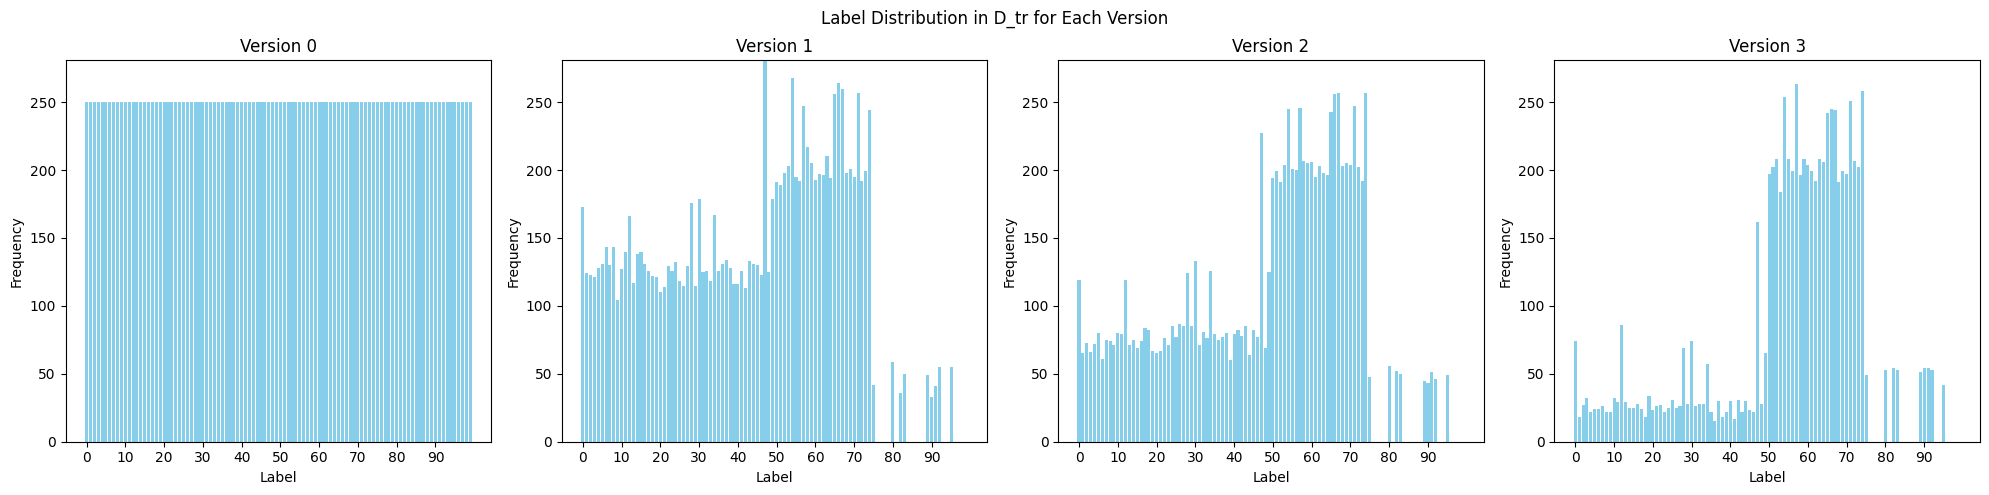

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

# 设置增量版本和类的数量
num_versions = 4  # 在 CIFAR-100 生成的数据集中有 4 个版本
num_classes = 100  # CIFAR-100 共有 100 个类


# 验证每个版本 D_tr 的标签分布变化并统一纵坐标
def plot_label_distribution(base_dir):
    plt.style.use("default")
    fig, axs = plt.subplots(1, num_versions, figsize=(20, 5))
    fig.suptitle("Label Distribution in D_tr for Each Version")

    max_count = 0  # 初始化最大频率值

    # 计算所有版本中的最大频率值
    for version in range(num_versions):
        _, labels = load_d_tr(version, base_dir)
        _, counts = np.unique(labels, return_counts=True)
        max_count = max(max_count, max(counts))

    # 绘图并设置统一的纵坐标
    for version in range(num_versions):
        _, labels = load_d_tr(version, base_dir)
        unique, counts = np.unique(labels, return_counts=True)

        # 为了保持 x 轴一致，确保横坐标是从 0 到 99（共100个类）
        full_counts = np.zeros(num_classes)
        full_counts[unique] = counts  # 填充实际的计数值

        axs[version].bar(range(num_classes), full_counts, color="skyblue")
        axs[version].set_title(f"Version {version}")
        axs[version].set_xlabel("Label")
        axs[version].set_ylabel("Frequency")
        axs[version].set_xticks(
            range(0, num_classes, 10)
        )  # 保证横轴一致，每隔 10 个类显示一次
        axs[version].set_ylim(0, max_count)  # 设置统一的纵坐标最大值

    plt.tight_layout()
    fig.subplots_adjust(top=0.88)  # 调整顶部以避免标题与图形重叠
    plt.show()


# 定义数据集的路径
base_dir = "../data/cifar-100/gen/nr_0.2_nt_asymmetric_balanced"
print("验证 base_dir 数据集:")
plot_label_distribution(base_dir)

根据输出结果来看，生成的数据符合预期：

1. **版本 0 到 3 的数据形状和标签数量**：

   - 数据量在每个版本中逐步减少，符合模拟遗忘的逻辑。
   - 版本 0 有 25000 条数据，版本 1 有 12500 条数据，版本 2 有 10000 条数据，版本 3 有 7500 条数据，数据量按预期减少。

2. **标签唯一值的变化**：
   - 在版本 0 中，所有 100 个类的标签均存在，这表明初始数据集包含了所有类别。
   - 从版本 1 开始，标签唯一值减少。例如，版本 1 到 3 中某些标签（如 76, 77, 78 等）消失。这符合遗忘类被移除的逻辑。

这种逐步减少类标签的情况表明，代码成功地对某些类别进行了遗忘模拟，符合增量学习和遗忘机制的设计目标。


### 验证遗忘


#### 条形图


验证 base_dir 数据集:
版本 0:
数据形状: (25000, 3, 32, 32), 标签形状: (25000,)
标签唯一值: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
版本 0:
数据形状: (25000, 3, 32, 32), 标签形状: (25000,)
标签唯一值: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
版本 0: 遗忘类数量: 0, 遗忘类: set()
版本 1:
数据形状: (12500, 3, 32, 32), 标签形状: (12500,)
标签唯一值: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59

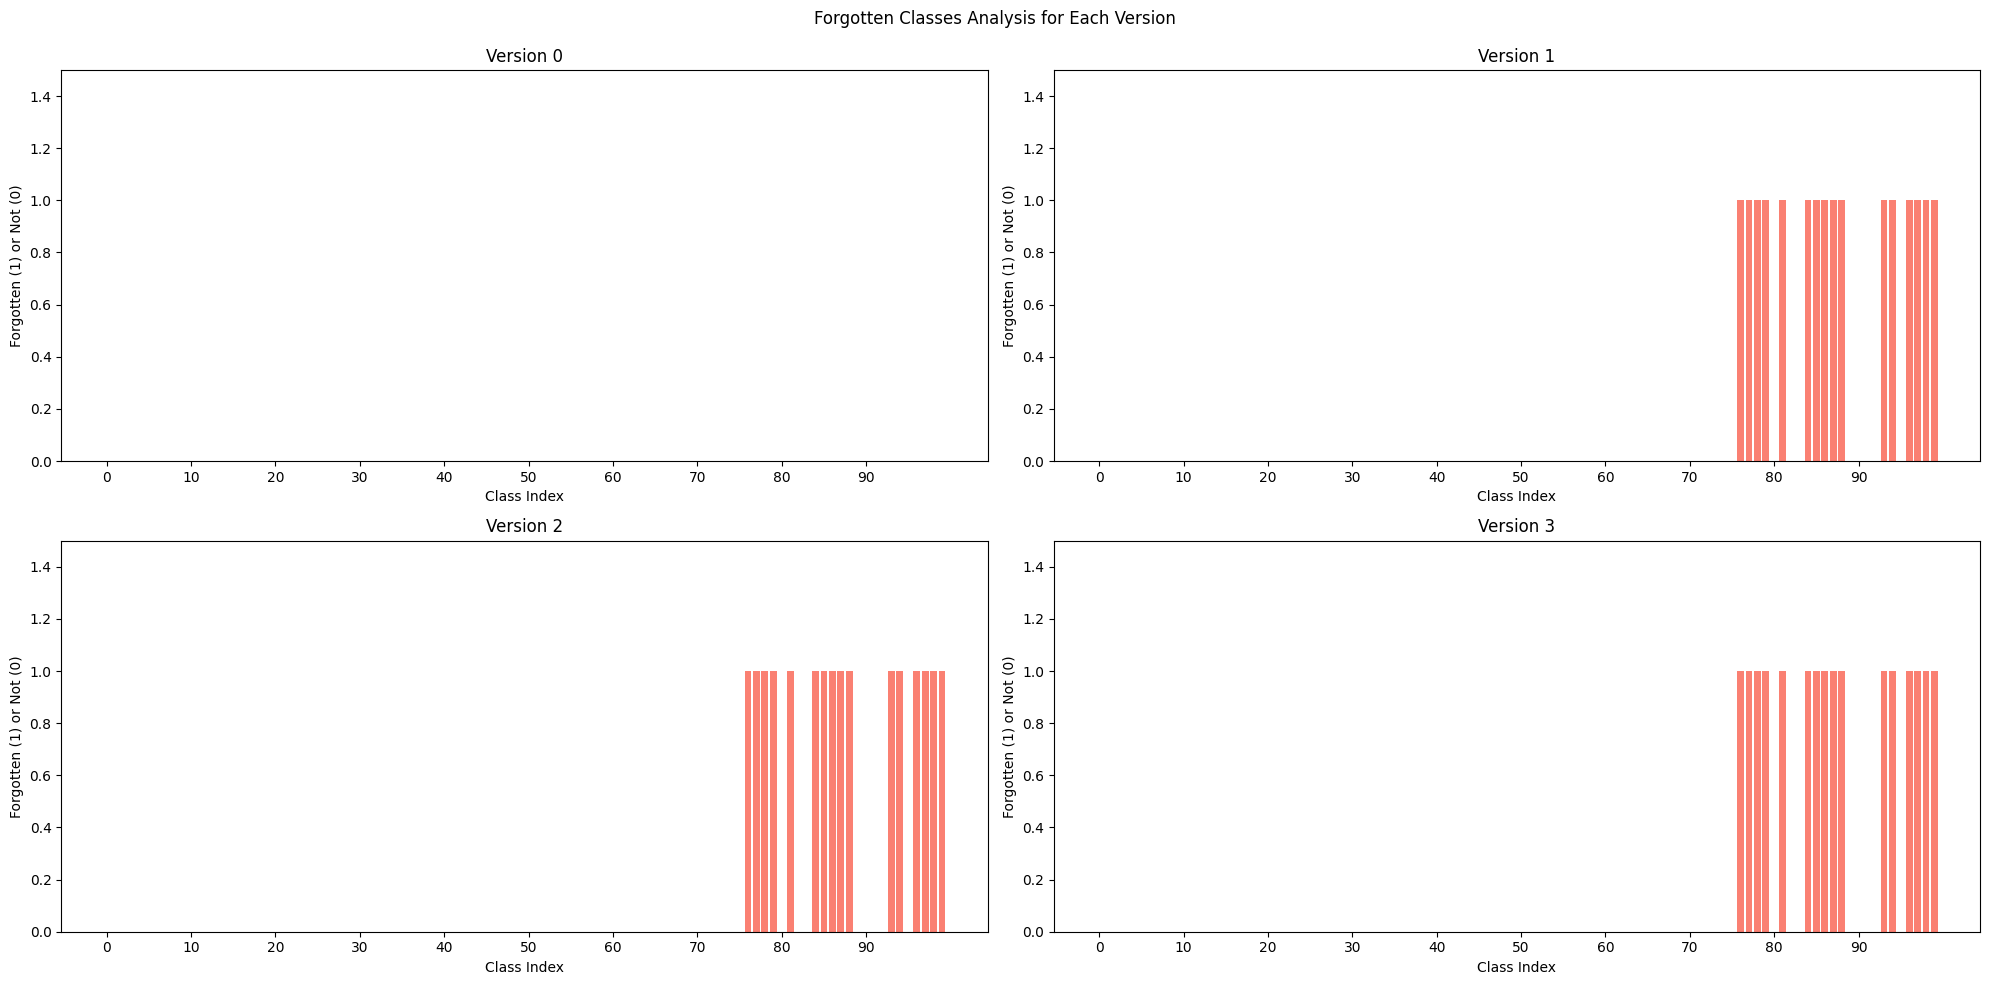

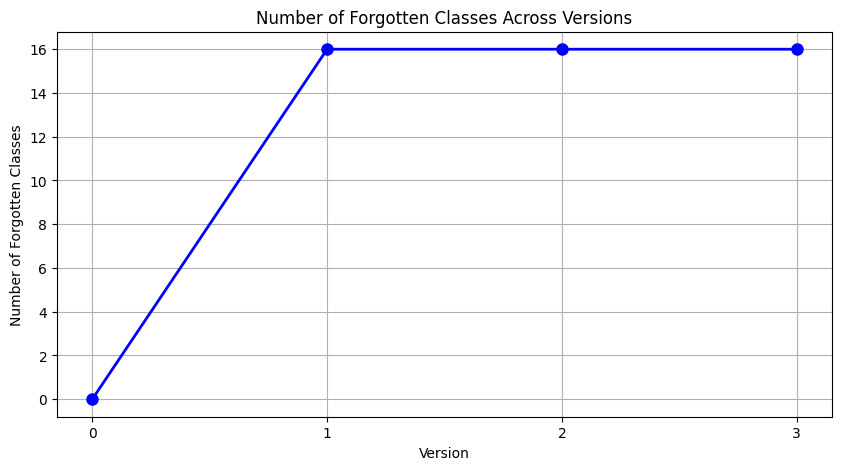

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

# 设置增量版本和类的数量
num_versions = 4  # 在 CIFAR-100 生成的数据集中有 4 个版本
num_classes = 100  # CIFAR-100 共有 100 个类


# 验证每个版本 D_tr 的标签分布变化并统一纵坐标，并计算遗忘类的统计信息
def plot_forgotten_classes_analysis(base_dir):
    plt.style.use("default")
    fig, axs = plt.subplots(2, 2, figsize=(20, 10))
    fig.suptitle("Forgotten Classes Analysis for Each Version")

    initial_labels = set(np.unique(load_d_tr(0, base_dir)[1]))
    forgotten_counts = []
    forgotten_classes_list = []

    # 计算每个版本中的遗忘类数量和遗忘类
    for version in range(num_versions):
        _, curr_labels = load_d_tr(version, base_dir)
        curr_classes = set(np.unique(curr_labels))

        forgotten_classes = initial_labels - curr_classes
        forgotten_counts.append(len(forgotten_classes))
        forgotten_classes_list.append(forgotten_classes)

        print(
            f"版本 {version}: 遗忘类数量: {len(forgotten_classes)}, 遗忘类: {forgotten_classes}"
        )

    max_count = max(forgotten_counts)  # 计算最大遗忘类数量，用于统一纵坐标

    # 绘制子图，展示每个版本的遗忘类数量和具体的遗忘类
    for version in range(num_versions):
        ax = axs[version // 2, version % 2]
        ax.bar(
            range(num_classes),
            [
                1 if i in forgotten_classes_list[version] else 0
                for i in range(num_classes)
            ],
            color="salmon",
        )
        ax.set_title(f"Version {version}")
        ax.set_xlabel("Class Index")
        ax.set_ylabel("Forgotten (1) or Not (0)")
        ax.set_xticks(range(0, num_classes, 10))
        ax.set_ylim(0, 1.5)  # 设定纵坐标统一范围，0 或 1 表示是否遗忘

    plt.tight_layout()
    fig.subplots_adjust(top=0.92)
    plt.show()

    # 绘制遗忘类数量的变化趋势
    plt.figure(figsize=(10, 5))
    plt.plot(
        range(num_versions),
        forgotten_counts,
        marker="o",
        color="b",
        linestyle="-",
        linewidth=2,
        markersize=8,
    )
    plt.title("Number of Forgotten Classes Across Versions")
    plt.xlabel("Version")
    plt.ylabel("Number of Forgotten Classes")
    plt.xticks(range(num_versions))
    plt.grid(True)
    plt.show()


# 定义数据集的路径
base_dir = "../data/cifar-100/gen/nr_0.2_nt_asymmetric_balanced"
print("验证 base_dir 数据集:")
plot_forgotten_classes_analysis(base_dir)

版本 0：没有被遗忘的类（如预期所示），因为版本 0 是初始数据集，包含所有的类，因此在图中所有类的标记为 0，即没有类被遗忘。

版本 1、2 和 3：版本 1、2 和 3 都显示相同数量的被遗忘类，并且都是相同的类（大约 16 个类）。这是合理的，因为版本 1 开始，某些类被遗忘，而版本 2 和 3 没有进一步遗忘更多的类。在可视化中，使用的条形图显示某些类别在每个版本中是否被遗忘（标记为 1）。所有被遗忘的类都在版本 1、2、3 中呈现出相似的图形，这表明这些类从版本 1 开始就被遗忘，并在后续版本中没有被重新引入。


### 2、验证噪声


In [3]:
!ls ../gen_dataset/

cifar-100_asymmetric_0.1_asymmetric_noisy_classes_detailed.json
cifar-100_asymmetric_0.1_asymmetric_noisy_classes_simple.json
cifar-100_asymmetric_0.2_asymmetric_noisy_classes_detailed.json
cifar-100_asymmetric_0.2_asymmetric_noisy_classes_simple.json
cifar-100_asymmetric_0.3_asymmetric_noisy_classes_detailed.json
cifar-100_asymmetric_0.3_asymmetric_noisy_classes_simple.json
cifar-100_asymmetric_0.5_asymmetric_noisy_classes_detailed.json
cifar-100_asymmetric_0.5_asymmetric_noisy_classes_simple.json
cifar-10-symmetric-0.1-symmetric_noisy_classes_detailed.json
cifar-10-symmetric-0.1-symmetric_noisy_classes_simple.json
cifar-10-symmetric-0.2-symmetric_noisy_classes_detailed.json
cifar-10-symmetric-0.2-symmetric_noisy_classes_simple.json
cifar-10-symmetric-0.3-symmetric_noisy_classes_detailed.json
cifar-10-symmetric-0.3-symmetric_noisy_classes_simple.json
cifar-10-symmetric-0.5-symmetric_noisy_classes_detailed.json
cifar-10-symmetric-0.5-symmetric_noisy_classes_simple.json
data
gen_cifar10

验证 base_dir 数据集:
版本 0:
数据形状: (25000, 3, 32, 32), 标签形状: (25000,)
标签唯一值: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
版本 1:
数据形状: (12500, 3, 32, 32), 标签形状: (12500,)
标签唯一值: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 80 82 83 89 90 91 92 95]
版本 2:
数据形状: (10000, 3, 32, 32), 标签形状: (10000,)
标签唯一值: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 80 82 83 89 90 91 92 95]
版

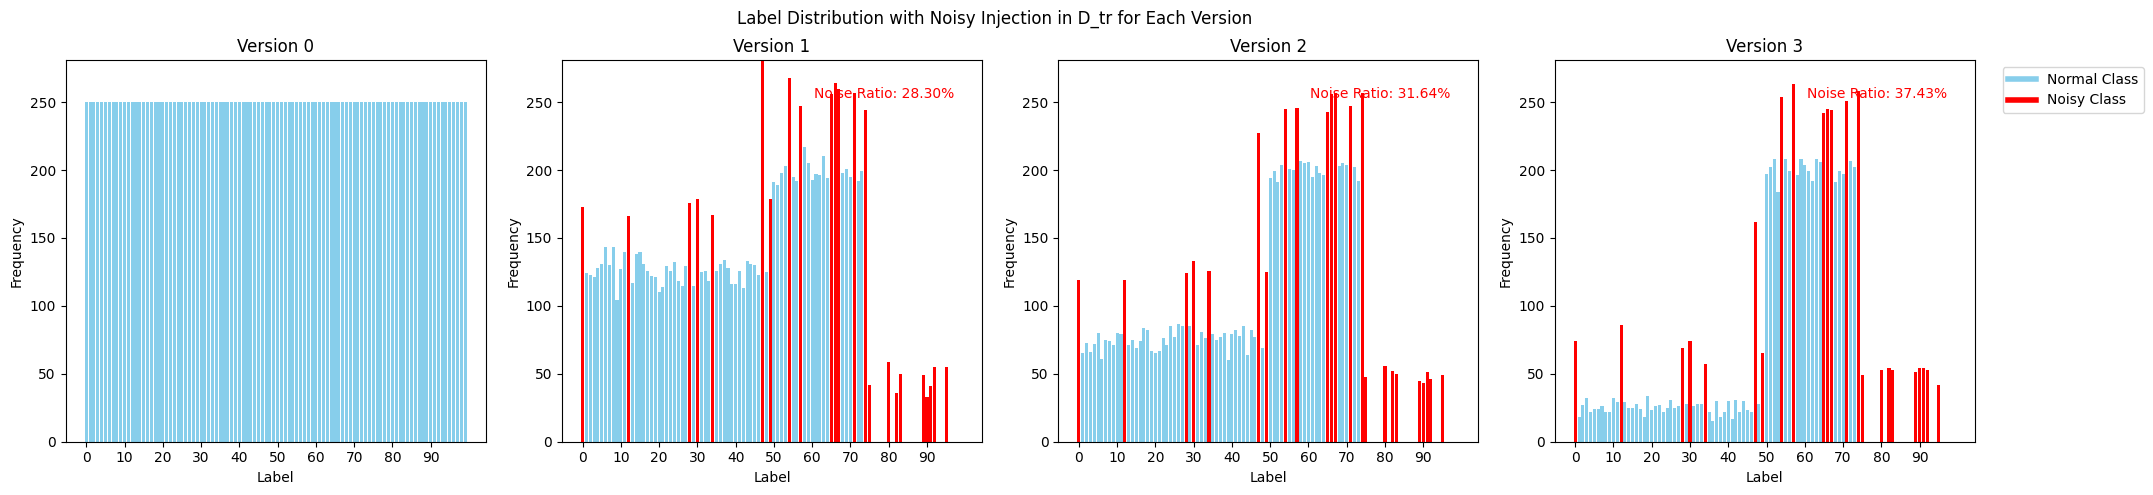

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import json

# 设置增量版本和类的数量
num_versions = 4  # 在 CIFAR-100 生成的数据集中有 4 个版本
num_classes = 100  # CIFAR-100 共有 100 个类


# 分析和验证噪声注入
# 从导出的 json 文件加载噪声映射关系
def load_noisy_mapping(json_file_path):
    with open(json_file_path, "r") as f:
        noisy_mapping = json.load(f)
    return noisy_mapping


# 验证噪声注入的标签分布
def plot_noisy_label_distribution(base_dir, noisy_json_path):
    noisy_mapping = load_noisy_mapping(noisy_json_path)

    plt.style.use("default")
    fig, axs = plt.subplots(1, num_versions, figsize=(20, 5))
    fig.suptitle("Label Distribution with Noisy Injection in D_tr for Each Version")

    max_count = 0  # 初始化最大频率值

    # 计算所有版本中的最大频率值
    for version in range(num_versions):
        _, labels = load_d_tr(version, base_dir)
        _, counts = np.unique(labels, return_counts=True)
        max_count = max(max_count, max(counts))

    # 绘图并设置统一的纵坐标
    for version in range(num_versions):
        _, labels = load_d_tr(version, base_dir)
        unique, counts = np.unique(labels, return_counts=True)

        # 为了保持 x 轴一致，确保横坐标是从 0 到 99（共100个类）
        full_counts = np.zeros(num_classes)
        full_counts[unique] = counts  # 填充实际的计数值

        # 标注噪声标签
        noisy_labels = set()
        for mapping in noisy_mapping:
            noisy_labels.add(mapping[1])

        if version == 0:
            # 初始版本没有注入噪声，用单一颜色显示
            colors = ["skyblue" for label in range(num_classes)]
        else:
            # 其他版本用不同颜色标记噪声标签
            colors = []
            for label in range(num_classes):
                if label in unique:
                    colors.append("red" if label in noisy_labels else "skyblue")
                else:
                    colors.append("skyblue")

        axs[version].bar(range(num_classes), full_counts, color=colors)
        axs[version].set_title(f"Version {version}")
        axs[version].set_xlabel("Label")
        axs[version].set_ylabel("Frequency")
        axs[version].set_xticks(range(0, num_classes, 10))  # 保证横轴一致
        axs[version].set_ylim(0, max_count)  # 设置统一的纵坐标最大值

        # 添加噪声比例注释，仅在版本 1 到 3 中添加
        if version > 0:
            noisy_count = sum(
                [
                    counts[np.where(unique == label)[0][0]]
                    for label in noisy_labels
                    if label in unique
                ]
            )
            total_count = sum(counts)
            noise_ratio = noisy_count / total_count if total_count > 0 else 0
            axs[version].annotate(
                f"Noise Ratio: {noise_ratio:.2%}",
                xy=(0.6, 0.9),
                xycoords="axes fraction",
                fontsize=10,
                color="red",
            )

    plt.tight_layout()
    fig.subplots_adjust(top=0.88)  # 调整顶部以避免标题与图形重叠
    plt.legend(
        handles=[
            plt.Line2D([0], [0], color="skyblue", lw=4, label="Normal Class"),
            plt.Line2D([0], [0], color="red", lw=4, label="Noisy Class"),
        ],
        loc="upper left",
        bbox_to_anchor=(1.05, 1),
    )
    plt.show()


# 定义数据集的路径和噪声映射文件路径
base_dir = "../data/cifar-100/gen/nr_0.2_nt_asymmetric_balanced"
noisy_json_path = (
    "../gen_dataset/cifar-100_asymmetric_0.2_asymmetric_noisy_classes_simple.json"
)

print("验证 base_dir 数据集:")
# plot_label_distribution(base_dir)
# plot_forgotten_classes_analysis(base_dir)
plot_noisy_label_distribution(base_dir, noisy_json_path)

1. **版本 0**：

   - 版本 0 中的标签分布是相对均匀的，各个类的频率大致相同。
   - 图中以红色显示的标签是被标记为噪声的类别。在初始版本中，这些类别均被标注为噪声（虽然噪声还未注入），以便之后的版本中进行替换。

2. **版本 1、2 和 3**：

   - **噪声注入后的变化**：

     - 在版本 1、2 和 3 中，可以看到红色的噪声类开始出现较高的频率，表明这些类别的样本数量增加了，符合噪声注入的预期。
     - 在这些版本中，噪声样本的引入导致某些类别（以红色显示）数量显著增多，而其他类别的频率有所下降。这表明某些类的标签被替换为噪声类。

   - **逐版本变化**：
     - 从版本 1 到版本 3，可以观察到噪声类的样本频率逐步增加，而正常类的样本数量逐步减少。这符合噪声比例逐渐增大的设定，即随着版本的增加，更多的样本被注入噪声，导致噪声类的占比不断上升。

3. **说明**

- **噪声标记与颜色显示**：

  - 红色用于标记被注入噪声的类别，这些类别的数量逐渐增多，符合噪声注入的逻辑。
  - 每个版本的噪声类与正常类之间的颜色对比（红色 vs. 蓝色）明确区分了哪些类受到了噪声注入，帮助理解噪声的影响范围。

- **噪声比例的变化**：
  - 噪声类的增加呈现出累积的效果，表明在每个增量版本中，有更多的样本被替换为噪声类。这种变化趋势符合代码逻辑中逐版本增加噪声比例的设计目标。


#### 小提琴图


Version 1: original_labels size = 25000, noisy_labels size = 21317
Version 2: original_labels size = 25000, noisy_labels size = 18844
Version 3: original_labels size = 25000, noisy_labels size = 16371


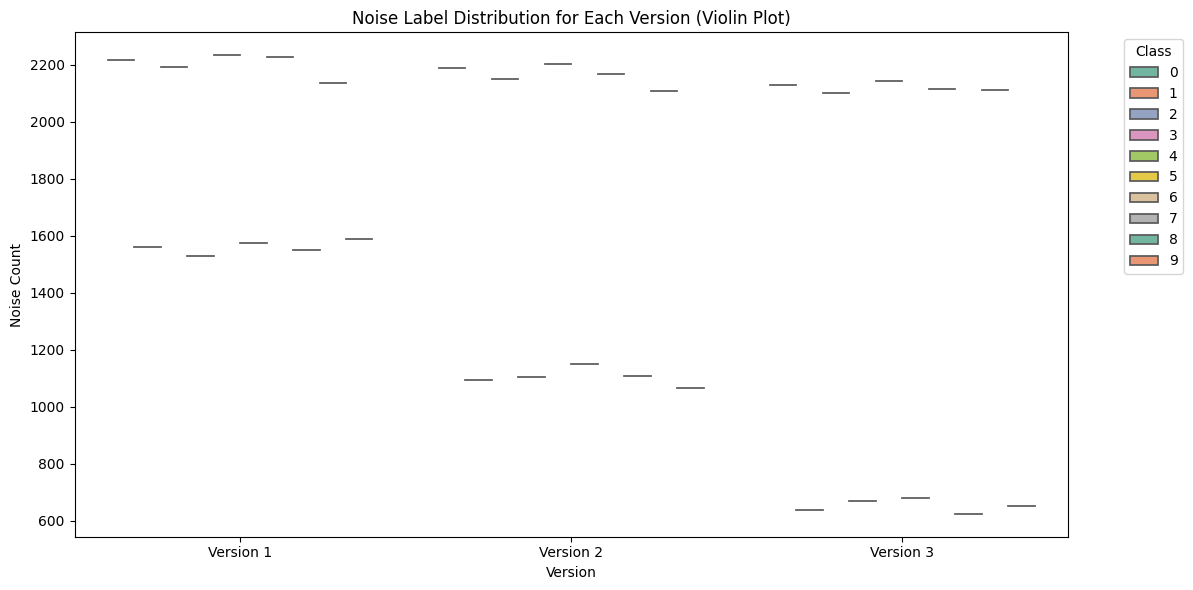

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch  # 添加torch库

num_versions = 3  # 假设有3个增量版本
num_classes = 10  # CIFAR-10 共有10个类
num_replay_samples = 2500  # D_a 包含的样本数


# 加载每个版本的原始标签和噪声标签
def load_labels(version, base_dir):
    original_labels_path = os.path.join(
        base_dir, "D_inc_0_labels.npy"
    )  # 修正为初始增量标签路径
    noisy_labels_path = os.path.join(base_dir, f"D_tr_labels_version_{version}.npy")

    try:
        original_labels = torch.load(original_labels_path).numpy()
        noisy_labels = torch.load(noisy_labels_path).numpy()

        # 输出标签的形状以进行调试
        print(
            f"Version {version}: original_labels size = {original_labels.size}, noisy_labels size = {noisy_labels.size}"
        )

        # 确保 noisy_labels 是一维数组
        if noisy_labels.ndim > 1:
            noisy_labels = noisy_labels.flatten()

        # 确保 noisy_labels 不会超过 original_labels 的长度
        if len(noisy_labels) > len(original_labels):
            noisy_labels = noisy_labels[: len(original_labels)]

        # 剔除重放数据 D_a 的标签部分
        noisy_labels = noisy_labels[num_replay_samples:]  # 从增量部分开始

        return original_labels, noisy_labels
    except Exception as e:
        print(f"Error loading labels for version {version}: {e}")
        return None, None


# 计算并可视化噪声标签比例的变化，使用小提琴图
def plot_noise_violin(base_dir):
    plt.style.use("default")
    plt.figure(figsize=(12, 6))  # 设置整体图像大小

    all_noise_data = []
    all_classes = []
    all_versions = []

    for version in range(1, num_versions + 1):
        original_labels, noisy_labels = load_labels(version, base_dir)
        if original_labels is None or noisy_labels is None:
            continue  # 跳过无法加载的版本

        # 统计噪声标签的数量
        noise_mask = original_labels != noisy_labels  # 标签不同的部分即为噪声
        noisy_labels_only = noisy_labels[noise_mask]

        # 对于每个类，计算噪声标签的数量并记录
        for label in range(num_classes):
            noise_per_class = np.sum(noisy_labels_only == label)

            # 记录所有噪声数据、对应的类以及版本
            all_noise_data.append(noise_per_class)  # 直接存储噪声标签数量
            all_classes.append(label)
            all_versions.append(f"Version {version}")

    # 使用Seaborn的小提琴图进行可视化
    sns.violinplot(
        x=all_versions,
        y=all_noise_data,
        hue=all_classes,
        split=True,
        inner="quart",
        palette="Set2",
    )
    plt.title("Noise Label Distribution for Each Version (Violin Plot)")
    plt.xlabel("Version")
    plt.ylabel("Noise Count")
    plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc="upper left")  # 添加图例
    plt.tight_layout()
    plt.show()


# 定义数据集的路径
base_dir = "../data/cifar-10/gen/nr_0.2_nt_symmetric"
# 验证并使用小提琴图可视化各版本中的标签噪声分布
plot_noise_violin(base_dir)

#### 热力图


对称噪声验证：
Version 1: original_labels size = 25000, noisy_labels size = 21317
Mismatch detected in version 1: Adjusting sizes
Version 2: original_labels size = 25000, noisy_labels size = 18844
Mismatch detected in version 2: Adjusting sizes
Version 3: original_labels size = 25000, noisy_labels size = 16371
Mismatch detected in version 3: Adjusting sizes


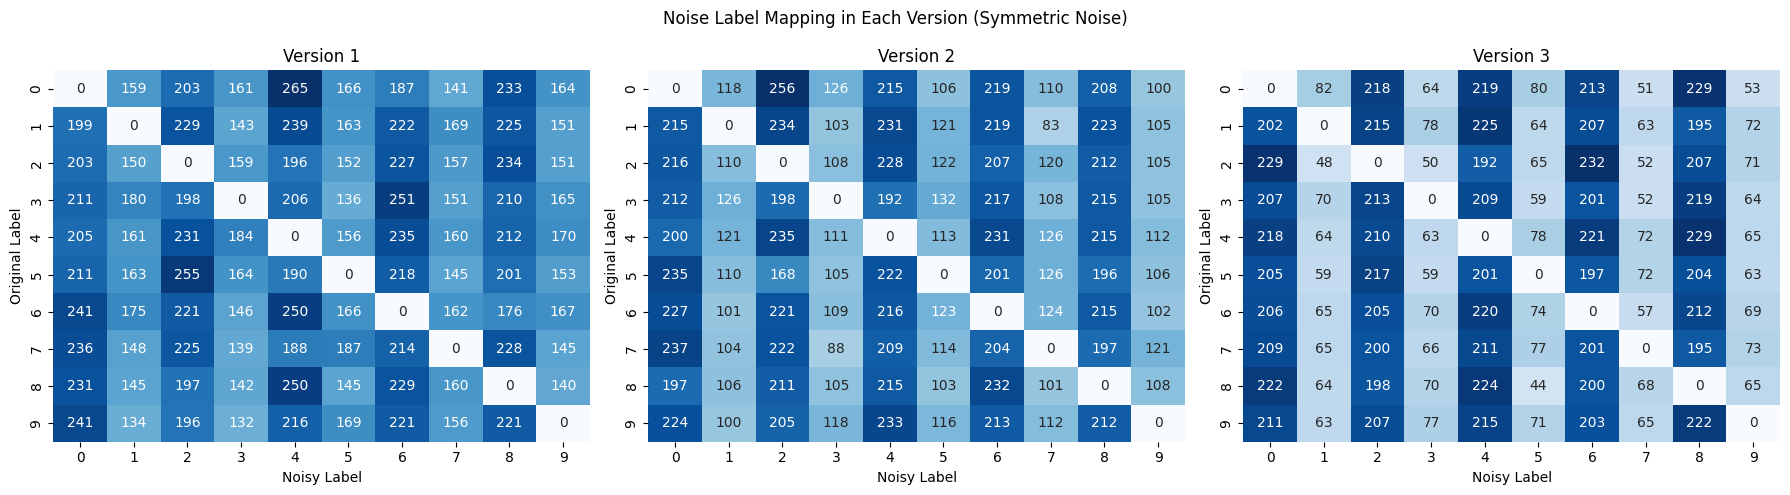

非对称噪声验证：
Error loading labels for version 1: [Errno 2] No such file or directory: '../data/cifar-10/gen/nr_0.2_nt_asymmetric/D_inc_0_labels.npy'
Error loading labels for version 2: [Errno 2] No such file or directory: '../data/cifar-10/gen/nr_0.2_nt_asymmetric/D_inc_0_labels.npy'
Error loading labels for version 3: [Errno 2] No such file or directory: '../data/cifar-10/gen/nr_0.2_nt_asymmetric/D_inc_0_labels.npy'


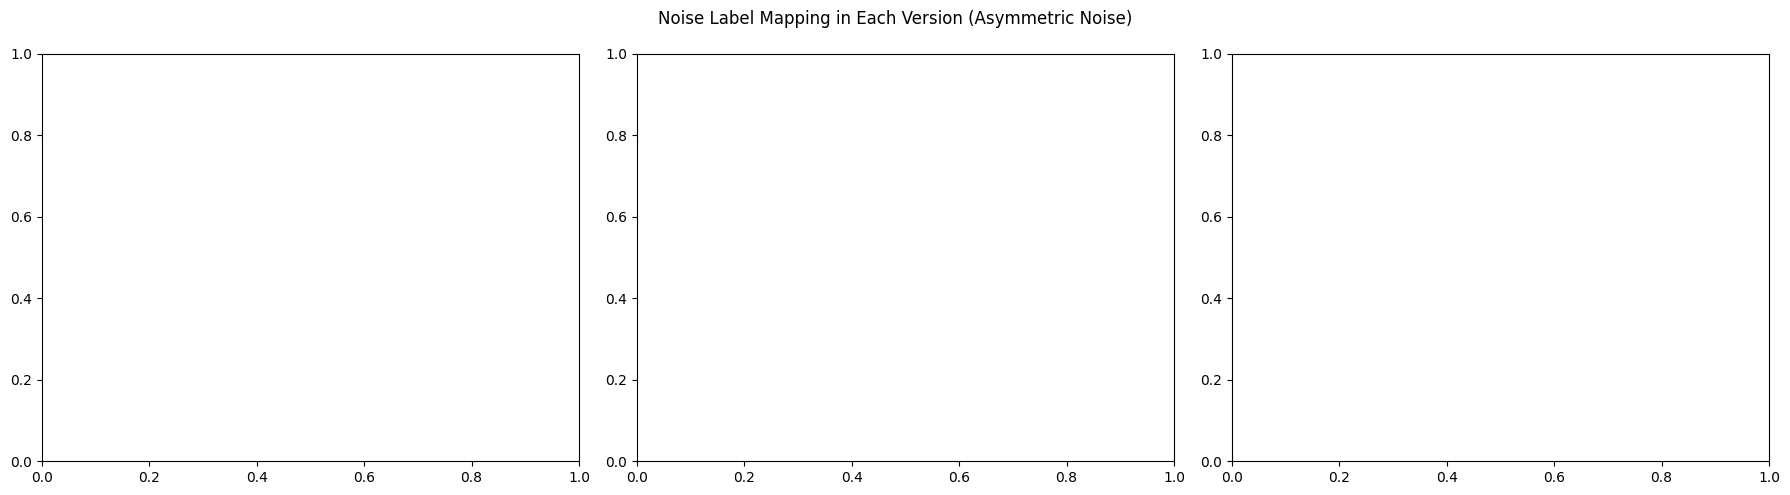

In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# 定义数据集的路径
base_dir_1 = "../data/cifar-10/gen/nr_0.2_nt_asymmetric"
base_dir_2 = "../data/cifar-10/gen/nr_0.2_nt_symmetric"
num_versions = 3  # 假设有3个增量版本
num_classes = 10  # CIFAR-10 共有10个类
num_replay_samples = 2500  # D_a 包含的样本数


# 加载每个版本的原始标签和噪声标签
def load_labels(version, base_dir):
    original_labels_path = os.path.join(
        base_dir, f"D_inc_0_labels.npy"
    )  # 固定增量标签文件名
    noisy_labels_path = os.path.join(base_dir, f"D_tr_labels_version_{version}.npy")

    try:
        original_labels = torch.load(
            original_labels_path
        ).numpy()  # 使用 torch.load 并转换为 numpy
        noisy_labels = torch.load(noisy_labels_path).numpy()

        # 调试输出标签的大小
        print(
            f"Version {version}: original_labels size = {len(original_labels)}, noisy_labels size = {len(noisy_labels)}"
        )

        # 剔除重放数据 D_a 的标签部分
        noisy_labels = noisy_labels[num_replay_samples:]  # 从增量部分开始

        # 确保 noisy_labels 和 original_labels 大小一致
        if len(noisy_labels) != len(original_labels):
            print(f"Mismatch detected in version {version}: Adjusting sizes")
            if len(noisy_labels) > len(original_labels):
                noisy_labels = noisy_labels[: len(original_labels)]
            else:
                original_labels = original_labels[: len(noisy_labels)]

        return original_labels, noisy_labels
    except Exception as e:
        print(f"Error loading labels for version {version}: {e}")
        return None, None


# 计算并可视化对称噪声和非对称噪声的效果
def plot_noise_effect(base_dir, noise_type):
    plt.style.use("default")
    fig, axs = plt.subplots(1, num_versions, figsize=(18, 5))
    fig.suptitle(f"Noise Label Mapping in Each Version ({noise_type} Noise)")

    for version in range(1, num_versions + 1):
        original_labels, noisy_labels = load_labels(version, base_dir)

        if original_labels is None or noisy_labels is None:
            continue  # 如果加载失败，则跳过该版本

        # 找到那些被噪声替换的样本
        noise_mask = original_labels != noisy_labels  # 标签不同的部分即为噪声
        original_labels_noisy = original_labels[noise_mask]
        noisy_labels_only = noisy_labels[noise_mask]

        # 构建噪声标签的映射矩阵
        noise_mapping_matrix = np.zeros(
            (num_classes, num_classes)
        )  # 记录每个类的噪声标签分布
        for orig, noisy in zip(original_labels_noisy, noisy_labels_only):
            noise_mapping_matrix[orig, noisy] += 1

        # 绘制热力图展示噪声标签的映射
        sns.heatmap(
            noise_mapping_matrix,
            ax=axs[version - 1],
            cmap="Blues",
            annot=True,
            fmt=".0f",
            cbar=False,
        )
        axs[version - 1].set_title(f"Version {version}")
        axs[version - 1].set_xlabel("Noisy Label")
        axs[version - 1].set_ylabel("Original Label")

    plt.tight_layout()
    plt.show()


# 验证对称噪声效果
print("对称噪声验证：")
plot_noise_effect(base_dir_2, "Symmetric")

# 验证非对称噪声效果
print("非对称噪声验证：")
plot_noise_effect(base_dir_1, "Asymmetric")

# CIFAR-100


## Test


Verifying Sampling Balance...
Analyzing dataset: symmetric_balanced


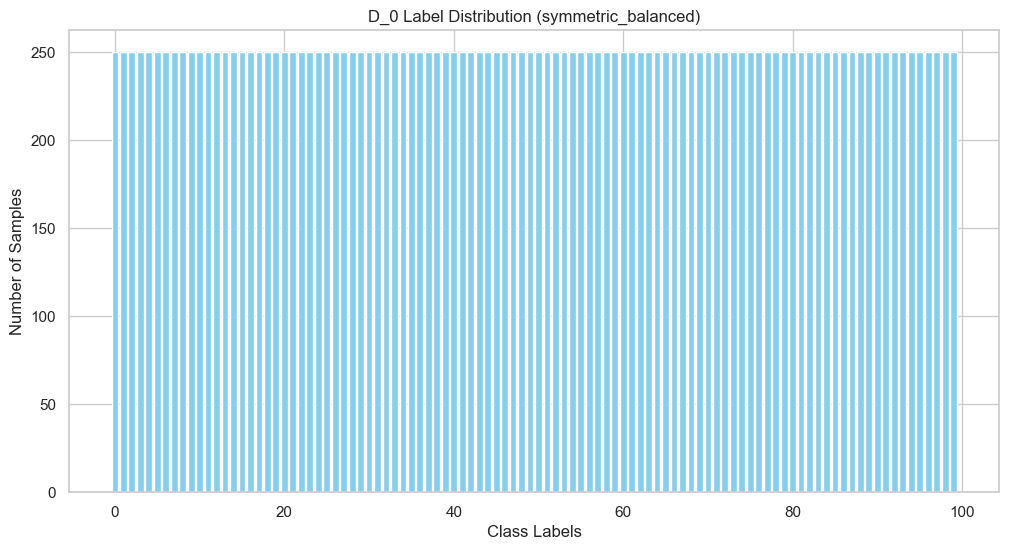

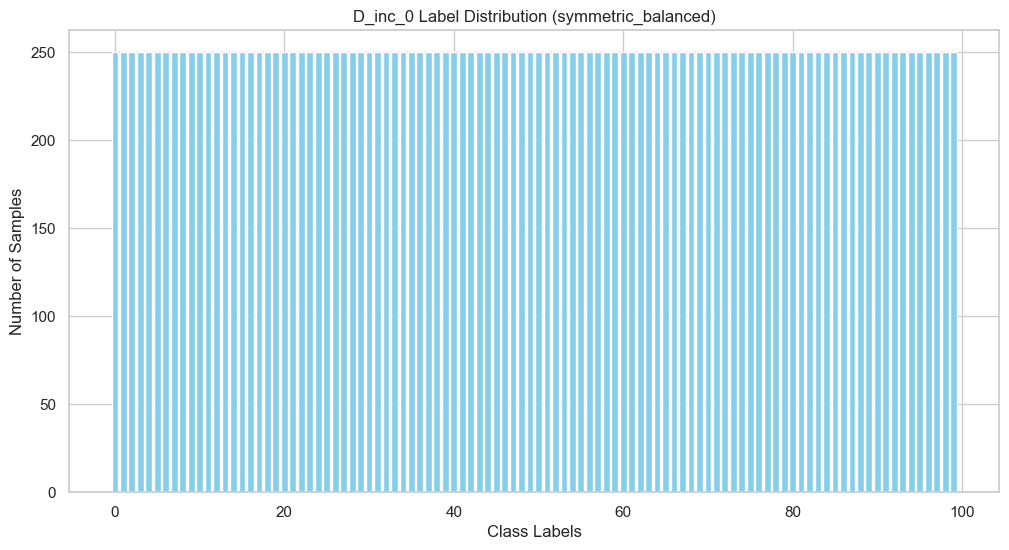

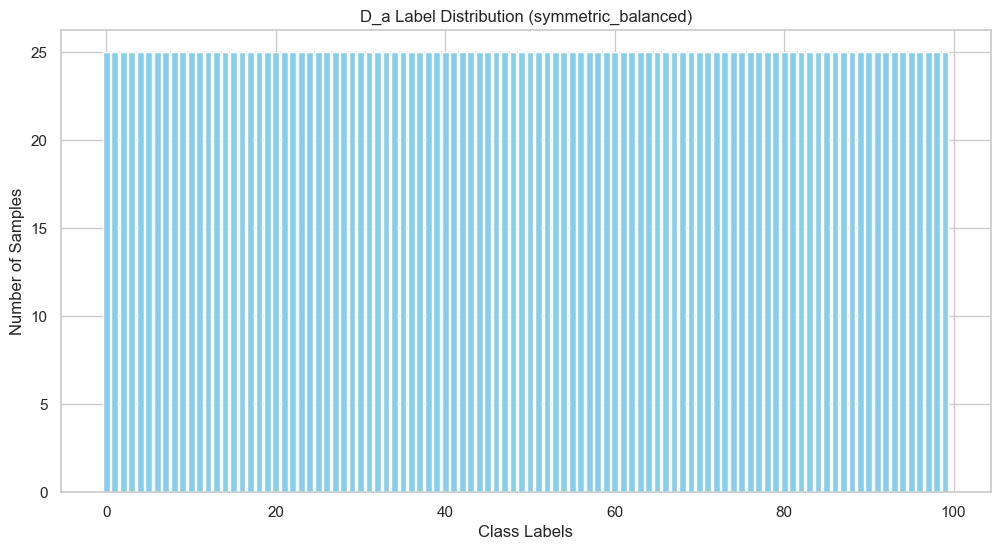

Verifying Forgetting Effect...
Analyzing dataset: symmetric_balanced


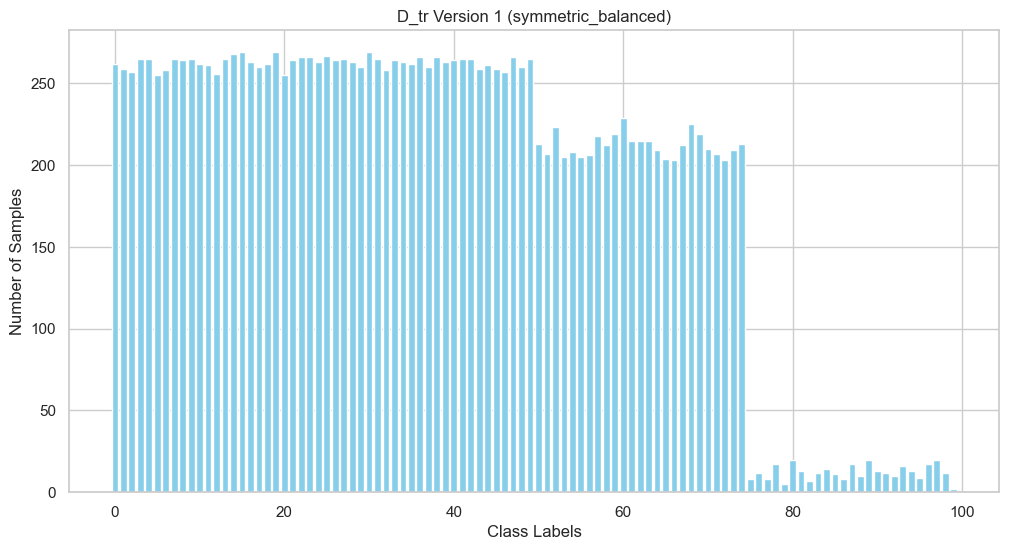

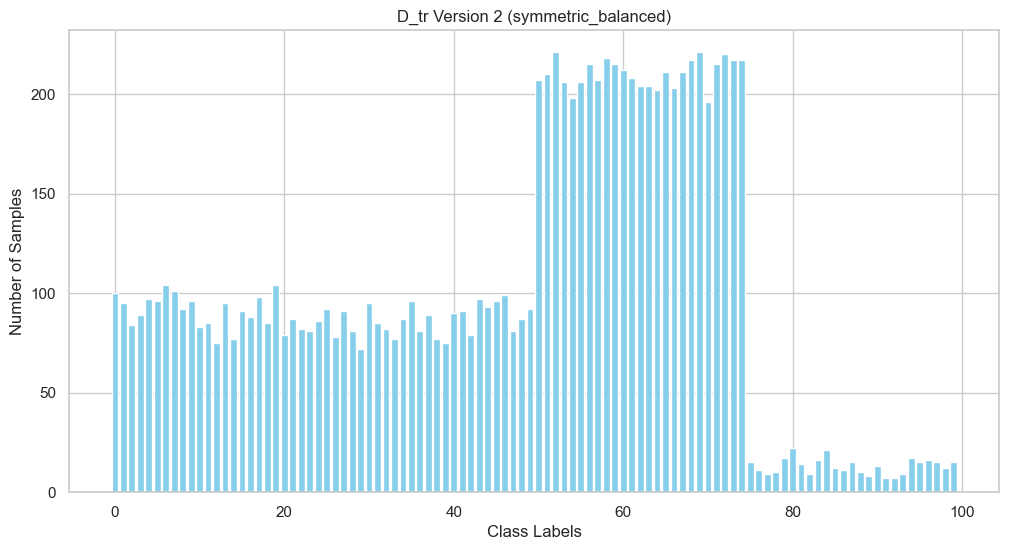

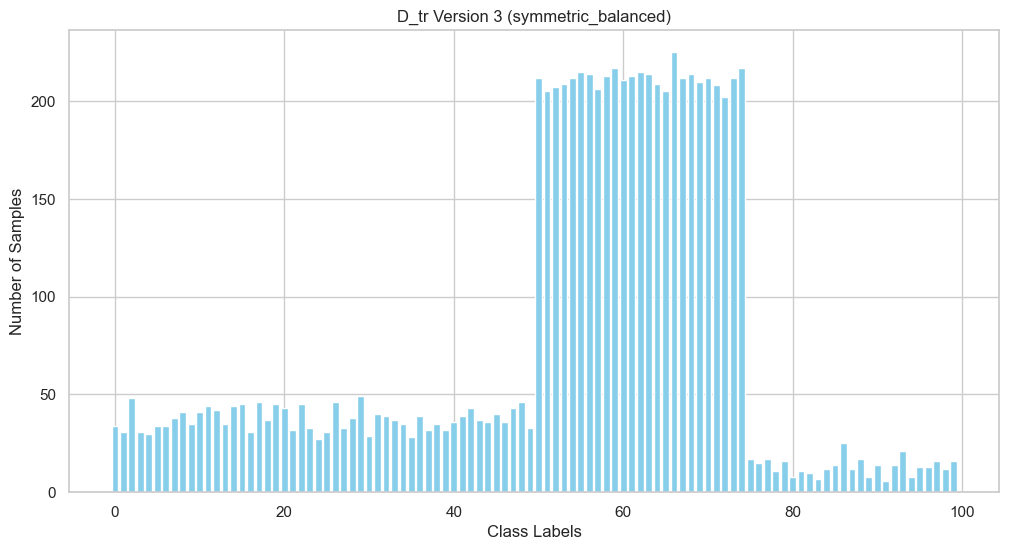

Verifying Noise Effect...
Analyzing dataset: symmetric_balanced
Noise effect for symmetric_balanced:


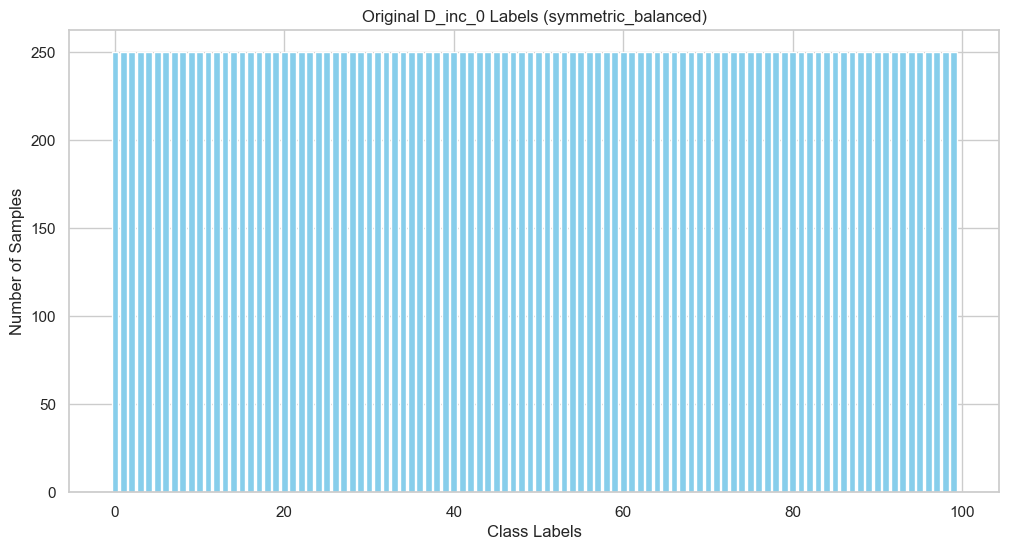

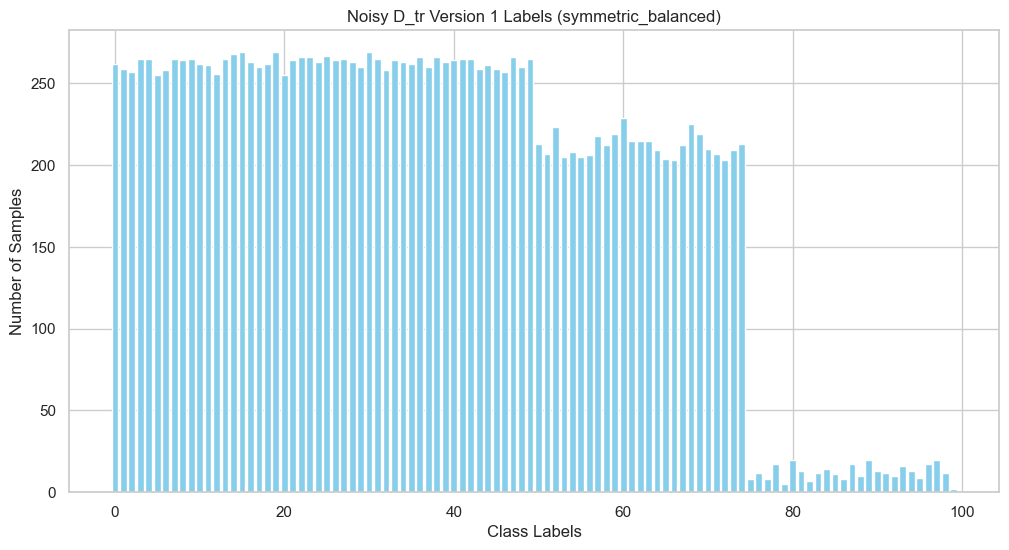

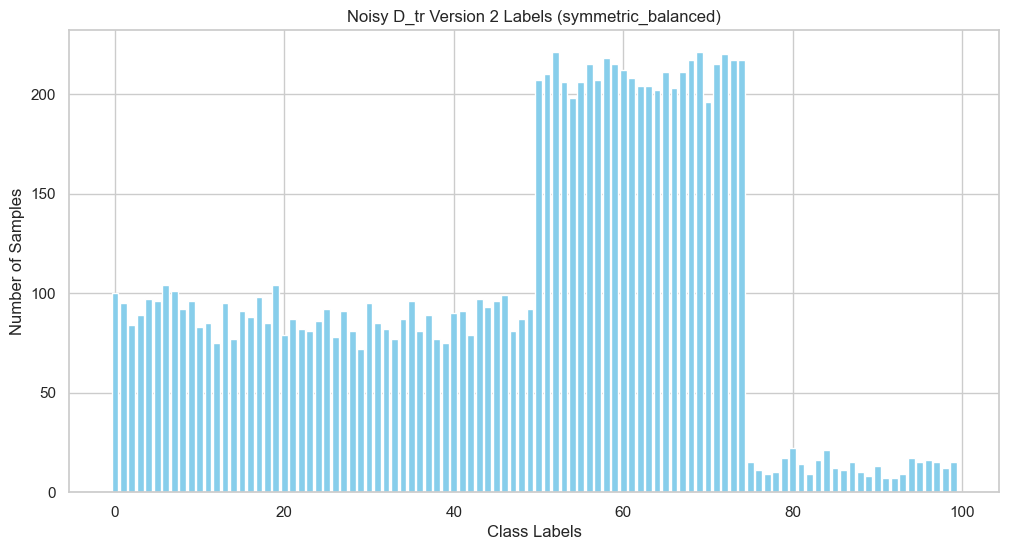

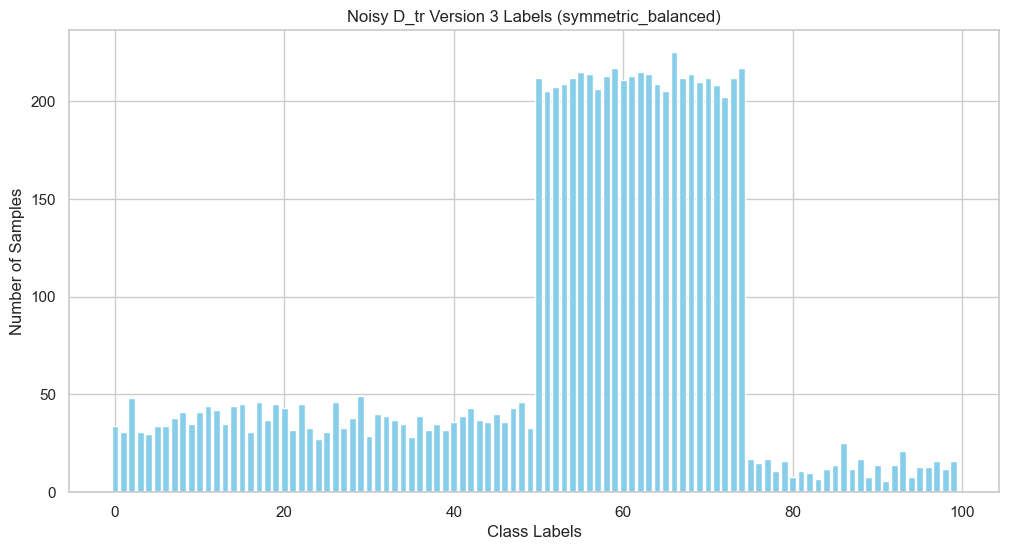

In [30]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# 设置 Seaborn 主题
sns.set(style="whitegrid")

# 文件路径
data_dirs = {
    # "symmetric": "../data/cifar-100/gen/nr_0.2_nt_symmetric",
    "symmetric_balanced": "../data/cifar-100/gen/nr_0.2_nt_symmetric_balanced",
    # "asymmetric": "../data/cifar-100/gen/nr_0.2_nt_asymmetric",
    # "asymmetric_balanced": "../data/cifar-100/gen/nr_0.2_nt_asymmetric_balanced",
}


# 加载数据函数
def load_data(data_dir):
    data = {}

    # 修改为 np.load 读取 .npy 文件
    data["train_data"] = np.load(f"{data_dir}/train_data.npy", allow_pickle=True)
    data["train_labels"] = np.load(f"{data_dir}/train_labels.npy", allow_pickle=True)

    data["test_data"] = np.load(f"{data_dir}/test_data.npy", allow_pickle=True)
    data["test_labels"] = np.load(f"{data_dir}/test_labels.npy", allow_pickle=True)

    data["D_0"] = np.load(f"{data_dir}/D_0.npy", allow_pickle=True)
    data["D_0_labels"] = np.load(f"{data_dir}/D_0_labels.npy", allow_pickle=True)

    data["D_inc_0"] = np.load(f"{data_dir}/D_inc_0_data.npy", allow_pickle=True)
    data["D_inc_0_labels"] = np.load(
        f"{data_dir}/D_inc_0_labels.npy", allow_pickle=True
    )

    data["D_a"] = np.load(f"{data_dir}/D_a.npy", allow_pickle=True)
    data["D_a_labels"] = np.load(f"{data_dir}/D_a_labels.npy", allow_pickle=True)

    # 加载增量训练版本
    data["D_tr_version_1"] = np.load(
        f"{data_dir}/D_tr_data_version_1.npy", allow_pickle=True
    )
    data["D_tr_labels_version_1"] = np.load(
        f"{data_dir}/D_tr_labels_version_1.npy", allow_pickle=True
    )
    data["D_tr_version_2"] = np.load(
        f"{data_dir}/D_tr_data_version_2.npy", allow_pickle=True
    )
    data["D_tr_labels_version_2"] = np.load(
        f"{data_dir}/D_tr_labels_version_2.npy", allow_pickle=True
    )
    data["D_tr_version_3"] = np.load(
        f"{data_dir}/D_tr_data_version_3.npy", allow_pickle=True
    )
    data["D_tr_labels_version_3"] = np.load(
        f"{data_dir}/D_tr_labels_version_3.npy", allow_pickle=True
    )

    return data


# 加载所有数据集
datasets = {name: load_data(path) for name, path in data_dirs.items()}


# 数据分析函数
def analyze_label_distribution(labels, title="Label Distribution"):
    label_counts = Counter(labels.tolist())  # 确保标签转为 list
    labels, counts = zip(*sorted(label_counts.items()))
    plt.figure(figsize=(12, 6))
    plt.bar(labels, counts, color="skyblue")
    plt.xlabel("Class Labels")
    plt.ylabel("Number of Samples")
    plt.title(title)
    plt.show()


# 验证 1：验证采样的随机效果和平衡效果
def verify_sampling_balance():
    print("Verifying Sampling Balance...")

    # 对比 D_0 和 D_inc_0 中的类别分布
    for name, dataset in datasets.items():
        print(f"Analyzing dataset: {name}")
        analyze_label_distribution(
            dataset["D_0_labels"], f"D_0 Label Distribution ({name})"
        )
        analyze_label_distribution(
            dataset["D_inc_0_labels"], f"D_inc_0 Label Distribution ({name})"
        )
        analyze_label_distribution(
            dataset["D_a_labels"], f"D_a Label Distribution ({name})"
        )


# 验证 2：验证数据遗忘效果
def verify_forgetting_effect():
    print("Verifying Forgetting Effect...")

    # 遍历每个增量版本，检查类别变化
    for name, dataset in datasets.items():
        print(f"Analyzing dataset: {name}")
        analyze_label_distribution(
            dataset["D_tr_labels_version_1"], f"D_tr Version 1 ({name})"
        )
        analyze_label_distribution(
            dataset["D_tr_labels_version_2"], f"D_tr Version 2 ({name})"
        )
        analyze_label_distribution(
            dataset["D_tr_labels_version_3"], f"D_tr Version 3 ({name})"
        )


# 验证 3：验证噪声效果（对称和非对称）
def verify_noise_effect():
    print("Verifying Noise Effect...")

    for name, dataset in datasets.items():
        print(f"Analyzing dataset: {name}")

        # 对比噪声注入前后的类别分布
        print(f"Noise effect for {name}:")
        analyze_label_distribution(
            dataset["D_inc_0_labels"], f"Original D_inc_0 Labels ({name})"
        )
        analyze_label_distribution(
            dataset["D_tr_labels_version_1"], f"Noisy D_tr Version 1 Labels ({name})"
        )
        analyze_label_distribution(
            dataset["D_tr_labels_version_2"], f"Noisy D_tr Version 2 Labels ({name})"
        )
        analyze_label_distribution(
            dataset["D_tr_labels_version_3"], f"Noisy D_tr Version 3 Labels ({name})"
        )


# 运行验证函数
verify_sampling_balance()
verify_forgetting_effect()
verify_noise_effect()

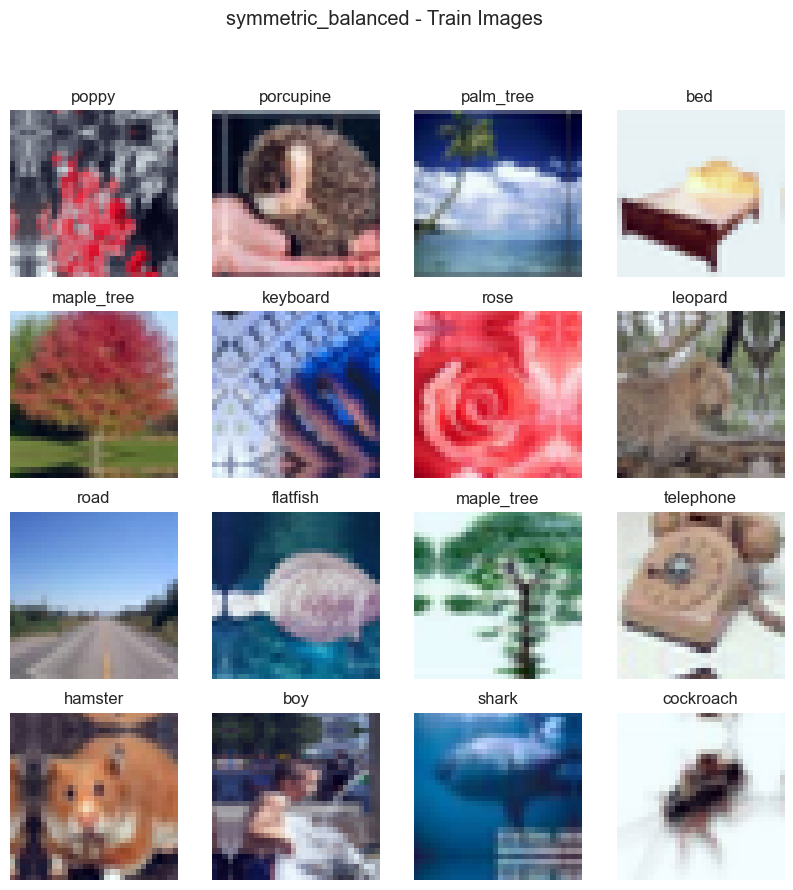

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 设置 Seaborn 主题
sns.set(style="whitegrid")


# 加载 CIFAR-100 类别名称
def load_class_names(file_path):
    with open(file_path, "r") as f:
        class_names = [line.strip() for line in f.readlines()]
    return class_names


# 假设类别名称文件存储在 'configs/classes/cifar_100_classes.txt'
class_names = load_class_names("../configs/classes/cifar_100_classes.txt")


# 加载数据函数
def load_data(data_dir):
    data = {}
    data["train_data"] = np.load(f"{data_dir}/train_data.npy", allow_pickle=True)
    data["train_labels"] = np.load(f"{data_dir}/train_labels.npy", allow_pickle=True)

    data["test_data"] = np.load(f"{data_dir}/test_data.npy", allow_pickle=True)
    data["test_labels"] = np.load(f"{data_dir}/test_labels.npy", allow_pickle=True)

    data["D_0"] = np.load(f"{data_dir}/D_0.npy", allow_pickle=True)
    data["D_0_labels"] = np.load(f"{data_dir}/D_0_labels.npy", allow_pickle=True)

    data["D_inc_0"] = np.load(f"{data_dir}/D_inc_0_data.npy", allow_pickle=True)
    data["D_inc_0_labels"] = np.load(
        f"{data_dir}/D_inc_0_labels.npy", allow_pickle=True
    )

    data["D_a"] = np.load(f"{data_dir}/D_a.npy", allow_pickle=True)
    data["D_a_labels"] = np.load(f"{data_dir}/D_a_labels.npy", allow_pickle=True)

    data["D_tr_version_1"] = np.load(
        f"{data_dir}/D_tr_data_version_1.npy", allow_pickle=True
    )
    data["D_tr_labels_version_1"] = np.load(
        f"{data_dir}/D_tr_labels_version_1.npy", allow_pickle=True
    )
    data["D_tr_version_2"] = np.load(
        f"{data_dir}/D_tr_data_version_2.npy", allow_pickle=True
    )
    data["D_tr_labels_version_2"] = np.load(
        f"{data_dir}/D_tr_labels_version_2.npy", allow_pickle=True
    )
    data["D_tr_version_3"] = np.load(
        f"{data_dir}/D_tr_data_version_3.npy", allow_pickle=True
    )
    data["D_tr_labels_version_3"] = np.load(
        f"{data_dir}/D_tr_labels_version_3.npy", allow_pickle=True
    )

    return data


# 数据集路径字典
data_dirs = {
    # "symmetric": "../data/cifar-100/gen/nr_0.2_nt_symmetric",
    "symmetric_balanced": "../data/cifar-100/gen/nr_0.2_nt_symmetric_balanced",
    # "asymmetric": "../data/cifar-100/gen/nr_0.2_nt_asymmetric",
    # "asymmetric_balanced": "../data/cifar-100/gen/nr_0.2_nt_asymmetric_balanced",
}

# 加载所有数据集
datasets = {name: load_data(path) for name, path in data_dirs.items()}


# 可视化函数，显示类别名称而非编号
def visualize_images(images, labels, num_images=16, title="Image Grid"):
    num_images = min(num_images, len(images))
    indices = np.random.choice(len(images), num_images, replace=False)
    selected_images = images[indices]
    selected_labels = labels[indices]

    grid_size = int(np.sqrt(num_images))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    axes = axes.flatten()

    for i in range(num_images):
        img = selected_images[i].transpose(1, 2, 0)  # 将图像维度转换为 HxWxC
        img = (img - img.min()) / (img.max() - img.min())  # 归一化图像到 [0, 1]

        class_name = class_names[selected_labels[i]]  # 将标签转换为类名
        axes[i].imshow(img)
        axes[i].set_title(f"{class_name}")
        axes[i].axis("off")

    plt.suptitle(title)
    plt.show()


# 使用某个数据集进行可视化
dataset_name = "symmetric_balanced"  # 选择对应的数据集键名
dataset = datasets[dataset_name]

# 可视化训练集中的部分图像和标签
visualize_images(
    dataset["train_data"],
    dataset["train_labels"],
    num_images=16,
    title=f"{dataset_name} - Train Images",
)
# visualize_images(
#     dataset["D_0"],
#     dataset["D_0_labels"],
#     num_images=16,
#     title=f"{dataset_name} - D_0 Images",
# )

# visualize_images(
#     dataset["D_inc_0"],
#     dataset["D_inc_0_labels"],
#     num_images=16,
#     title=f"{dataset_name} - D_inc_0 Images",
# )
# visualize_images(
#     dataset["D_tr_version_1"],
#     dataset["D_tr_labels_version_1"],
#     num_images=16,
#     title=f"{dataset_name} - D_tr_version_1 Images",
# )

## 验证


### 验证遗忘


### 验证噪声


/tmp/ipykernel_217127/3375354811.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  original_labels = torch.load(original_labels_path).numpy()  # 使用 torch.load
/tmp/ipyker

Version 1: original_labels size = 25000, noisy_labels size = 14986
Version 2: original_labels size = 25000, noisy_labels size = 12514
Version 3: original_labels size = 25000, noisy_labels size = 10043


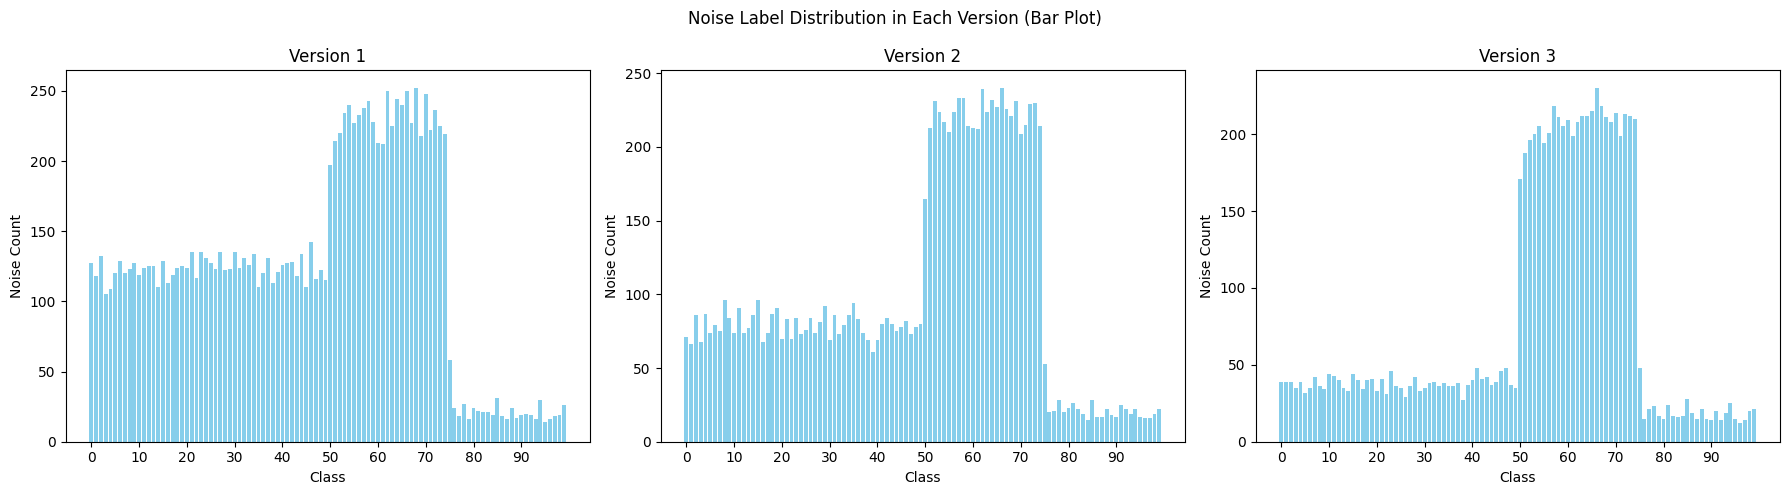

/tmp/ipykernel_217127/3375354811.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  original_labels = torch.load(original_labels_path).numpy()  # 使用 torch.load
/tmp/ipyker

Version 1: original_labels size = 25000, noisy_labels size = 14986
Version 2: original_labels size = 25000, noisy_labels size = 12514
Version 3: original_labels size = 25000, noisy_labels size = 10043


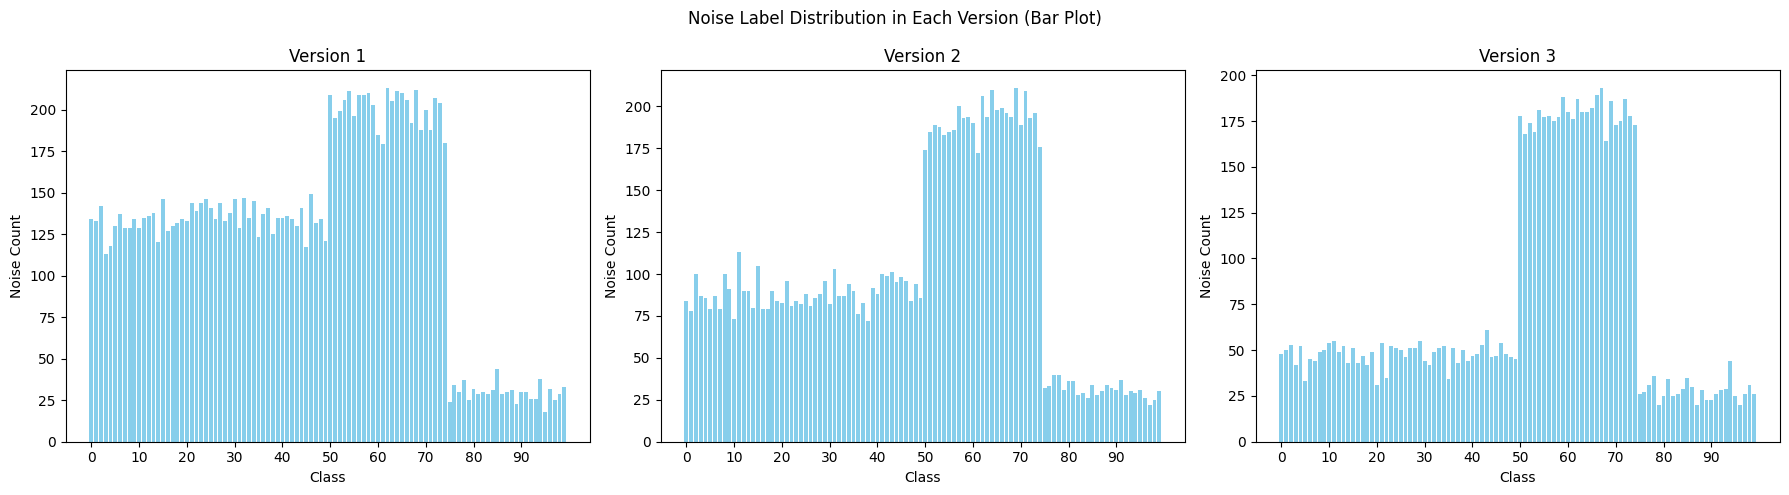

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

# 定义数据集的路径
base_dir_asym = "../data/cifar-100/gen/nr_0.2_nt_asymmetric"
base_dir_sym = "../data/cifar-100/gen/nr_0.2_nt_symmetric"
num_versions = 3  # 假设有3个增量版本
num_classes = 100  # CIFAR-100 共有100个类
num_replay_samples = 2500  # D_a 包含的样本数


# 加载每个版本的原始标签和噪声标签
def load_labels(version, base_dir):
    original_labels_path = os.path.join(
        base_dir, f"D_inc_0_labels.npy"
    )  # 使用固定的增量标签文件
    noisy_labels_path = os.path.join(base_dir, f"D_tr_labels_version_{version}.npy")

    try:
        original_labels = torch.load(original_labels_path).numpy()  # 使用 torch.load
        noisy_labels = torch.load(noisy_labels_path).numpy()

        # 调试输出标签的大小
        print(
            f"Version {version}: original_labels size = {original_labels.size}, noisy_labels size = {noisy_labels.size}"
        )

        # 剔除重放数据 D_a 的标签部分
        noisy_labels = noisy_labels[num_replay_samples:]  # 从增量部分开始

        # 确保 noisy_labels 与 original_labels 大小一致
        if len(noisy_labels) > len(original_labels):
            noisy_labels = noisy_labels[: len(original_labels)]

        return original_labels, noisy_labels
    except Exception as e:
        print(f"Error loading labels for version {version}: {e}")
        return None, None


# 计算并使用条形图显示噪声标签的分布
def plot_noise_bar(base_dir):
    plt.style.use("default")
    fig, axs = plt.subplots(1, num_versions, figsize=(18, 5))
    fig.suptitle("Noise Label Distribution in Each Version (Bar Plot)")

    for version in range(1, num_versions + 1):
        original_labels, noisy_labels = load_labels(version, base_dir)

        if original_labels is None or noisy_labels is None:
            continue  # 如果加载失败，则跳过该版本

        # 统计噪声标签的数量
        noise_mask = original_labels != noisy_labels  # 标签不同的部分即为噪声
        noisy_labels_only = noisy_labels[noise_mask]

        # 统计每个类的噪声标签数量
        noise_counts = np.zeros(num_classes)
        for label in range(num_classes):
            noise_counts[label] = np.sum(noisy_labels_only == label)

        # 绘制条形图
        axs[version - 1].bar(range(num_classes), noise_counts, color="skyblue")
        axs[version - 1].set_title(f"Version {version}")
        axs[version - 1].set_xlabel("Class")
        axs[version - 1].set_ylabel("Noise Count")
        axs[version - 1].set_xticks(range(0, num_classes, 10))  # 每10个类显示一次标签

    plt.tight_layout()
    plt.show()


# 验证并使用条形图可视化各版本中的标签噪声分布
plot_noise_bar(base_dir_asym)
plot_noise_bar(base_dir_sym)

对称噪声验证：
Version 1: original_labels size = 25000, noisy_labels size = 14986
Mismatch detected in version 1: Adjusting sizes
Version 2: original_labels size = 25000, noisy_labels size = 12514
Mismatch detected in version 2: Adjusting sizes


/tmp/ipykernel_217127/3043773983.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  original_labels = torch.load(original_labels_path).numpy()  # 使用 torch.load 并转换为 numpy


Version 3: original_labels size = 25000, noisy_labels size = 10043
Mismatch detected in version 3: Adjusting sizes


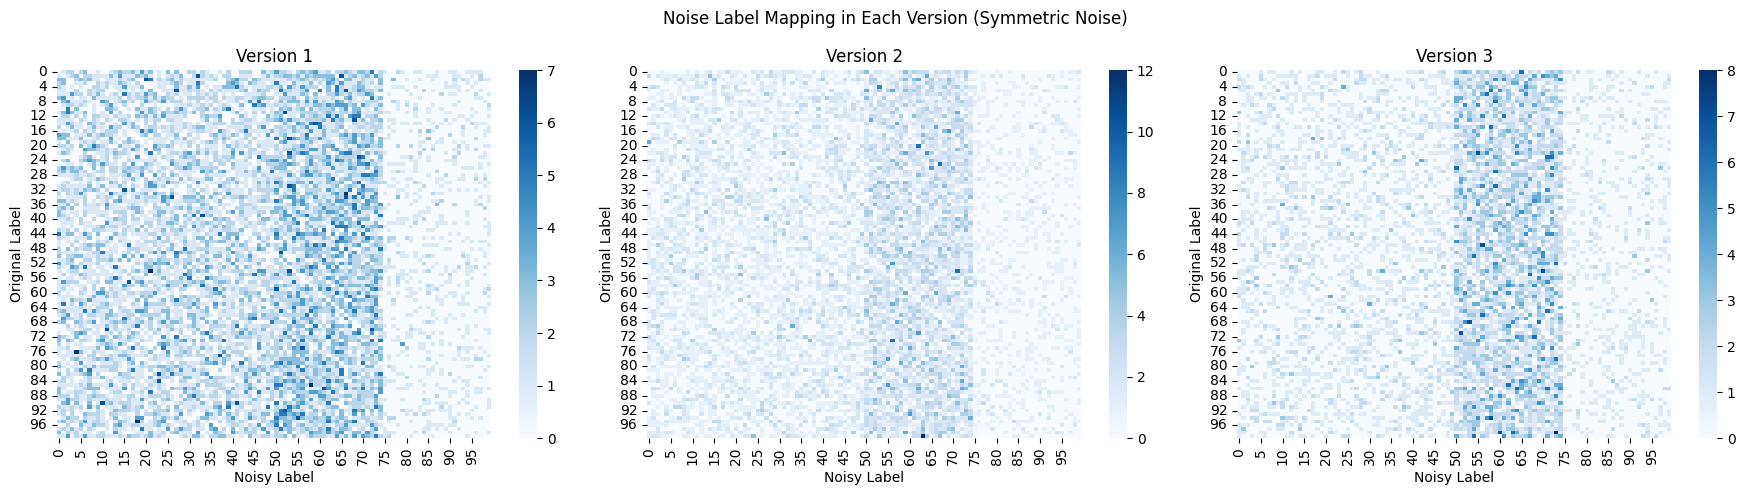

非对称噪声验证：
Version 1: original_labels size = 25000, noisy_labels size = 14986
Mismatch detected in version 1: Adjusting sizes


/tmp/ipykernel_217127/3043773983.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  original_labels = torch.load(original_labels_path).numpy()  # 使用 torch.load 并转换为 numpy


Version 2: original_labels size = 25000, noisy_labels size = 12514
Mismatch detected in version 2: Adjusting sizes
Version 3: original_labels size = 25000, noisy_labels size = 10043
Mismatch detected in version 3: Adjusting sizes


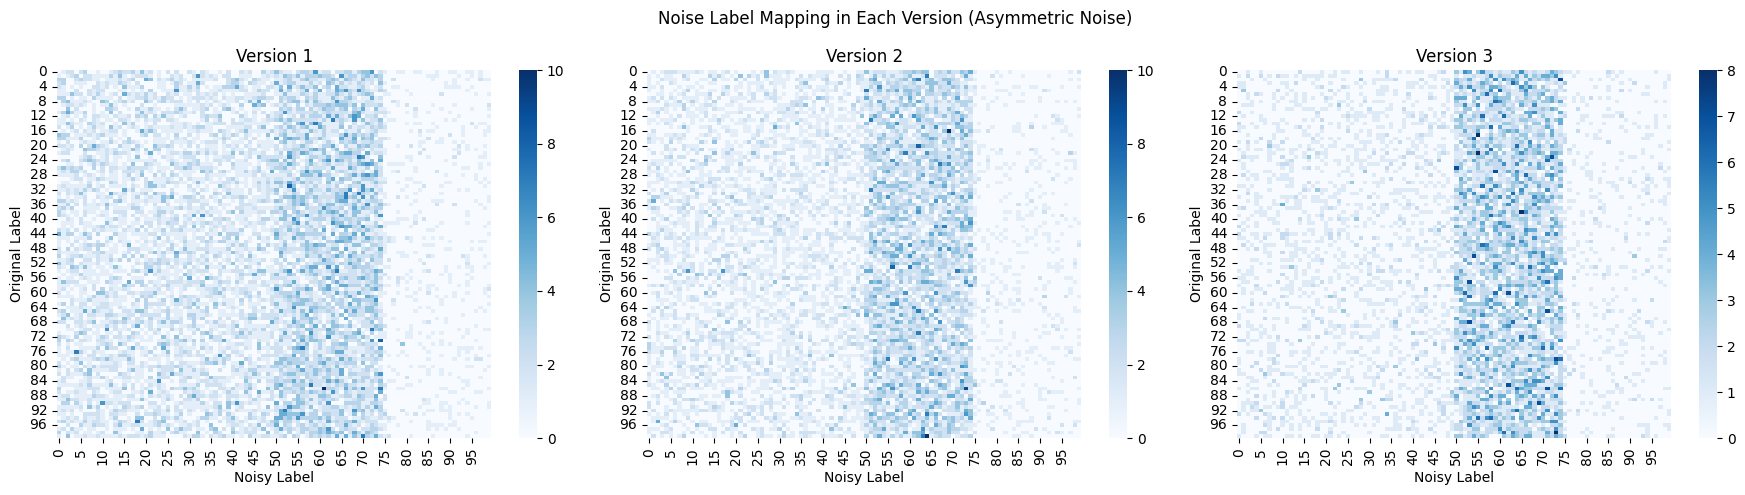

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# 定义数据集的路径
base_dir_asym = "../data/cifar-100/gen/nr_0.2_nt_asymmetric"
base_dir_sym = "../data/cifar-100/gen/nr_0.2_nt_symmetric"
num_versions = 3  # 假设有3个增量版本
num_classes = 100  # CIFAR-100 共有100个类
num_replay_samples = 2500  # D_a 包含的样本数


# 加载每个版本的原始标签和噪声标签
def load_labels(version, base_dir):
    original_labels_path = os.path.join(
        base_dir, f"D_inc_0_labels.npy"
    )  # 固定增量标签文件名
    noisy_labels_path = os.path.join(base_dir, f"D_tr_labels_version_{version}.npy")

    try:
        original_labels = torch.load(
            original_labels_path
        ).numpy()  # 使用 torch.load 并转换为 numpy
        noisy_labels = torch.load(noisy_labels_path).numpy()

        # 调试输出标签的大小
        print(
            f"Version {version}: original_labels size = {len(original_labels)}, noisy_labels size = {len(noisy_labels)}"
        )

        # 剔除重放数据 D_a 的标签部分
        noisy_labels = noisy_labels[num_replay_samples:]  # 从增量部分开始

        # 确保 noisy_labels 和 original_labels 大小一致
        if len(noisy_labels) != len(original_labels):
            print(f"Mismatch detected in version {version}: Adjusting sizes")
            if len(noisy_labels) > len(original_labels):
                noisy_labels = noisy_labels[: len(original_labels)]
            else:
                original_labels = original_labels[: len(noisy_labels)]

        return original_labels, noisy_labels
    except Exception as e:
        print(f"Error loading labels for version {version}: {e}")
        return None, None


# 计算并可视化对称噪声和非对称噪声的效果
def plot_noise_effect(base_dir, noise_type):
    plt.style.use("default")
    fig, axs = plt.subplots(1, num_versions, figsize=(18, 5))
    fig.suptitle(f"Noise Label Mapping in Each Version ({noise_type} Noise)")

    for version in range(1, num_versions + 1):
        original_labels, noisy_labels = load_labels(version, base_dir)

        if original_labels is None or noisy_labels is None:
            continue  # 如果加载失败，则跳过该版本

        # 找到那些被噪声替换的样本
        noise_mask = original_labels != noisy_labels  # 标签不同的部分即为噪声
        original_labels_noisy = original_labels[noise_mask]
        noisy_labels_only = noisy_labels[noise_mask]

        # 构建噪声标签的映射矩阵
        noise_mapping_matrix = np.zeros(
            (num_classes, num_classes)
        )  # 记录每个类的噪声标签分布
        for orig, noisy in zip(original_labels_noisy, noisy_labels_only):
            noise_mapping_matrix[orig, noisy] += 1

        # 绘制热力图展示噪声标签的映射
        sns.heatmap(noise_mapping_matrix, ax=axs[version - 1], cmap="Blues", cbar=True)
        axs[version - 1].set_title(f"Version {version}")
        axs[version - 1].set_xlabel("Noisy Label")
        axs[version - 1].set_ylabel("Original Label")

    plt.tight_layout()
    plt.show()


# 验证对称噪声效果
print("对称噪声验证：")
plot_noise_effect(base_dir_sym, "Symmetric")

# 验证非对称噪声效果
print("非对称噪声验证：")
plot_noise_effect(base_dir_asym, "Asymmetric")

# TEST CODES


visualization


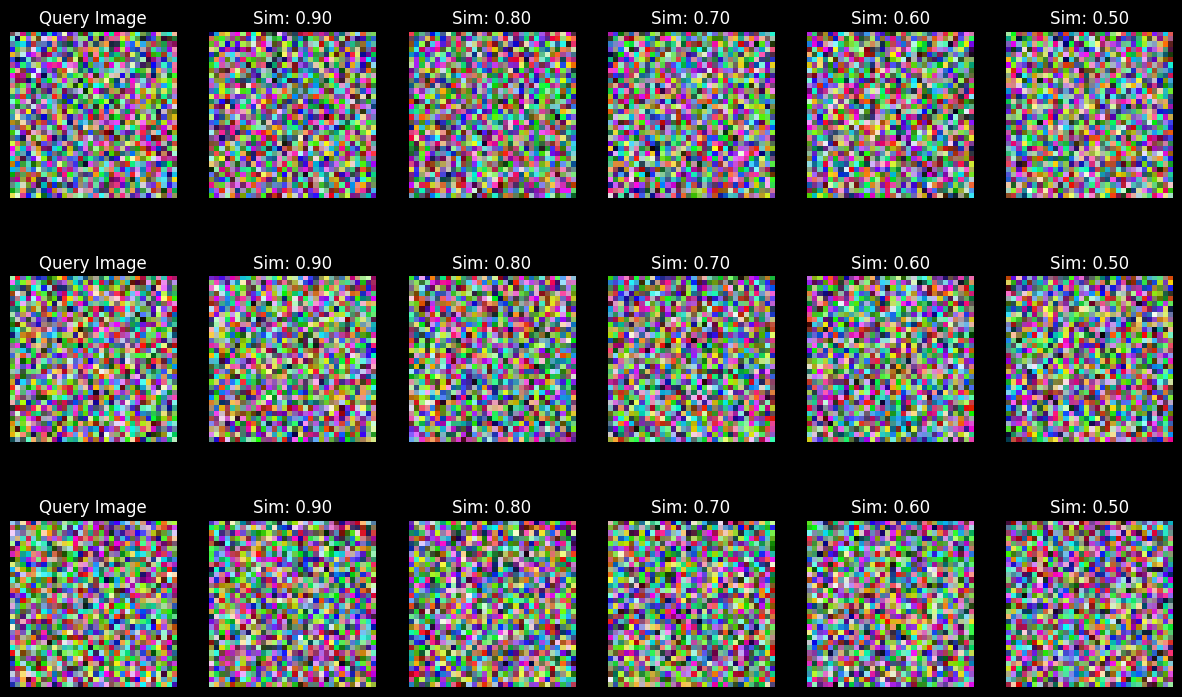

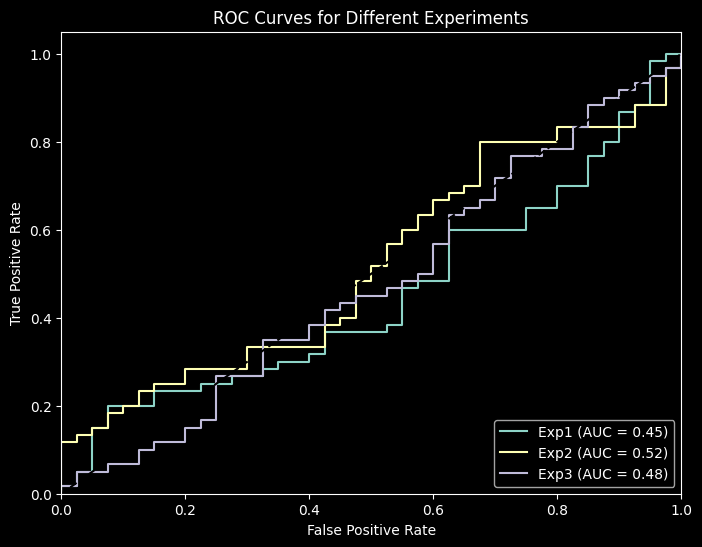

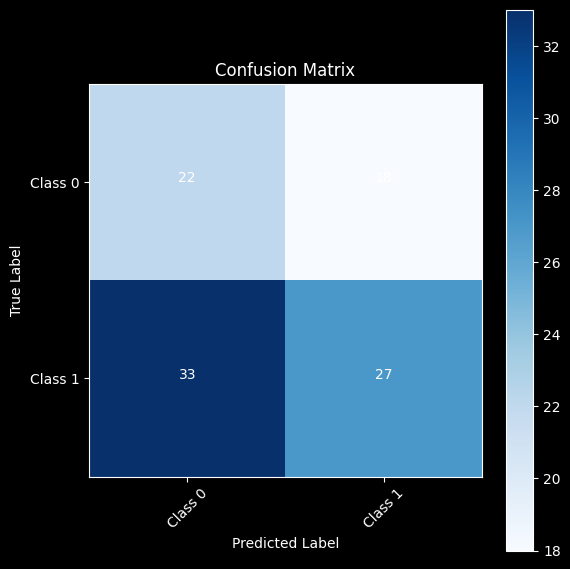

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import roc_curve, auc, confusion_matrix

# 假数据生成
np.random.seed(42)

# 1. 假设的相似度评分 (0-1之间)
sim_scores_exp1 = np.random.rand(5)
sim_scores_exp2 = np.random.rand(5)
sim_scores_exp3 = np.random.rand(5)

# 2. 假设的分类模型的ROC曲线数据 (基于随机预测的假数据)
y_true = np.random.randint(0, 2, 100)
y_scores_exp1 = np.random.rand(100)
y_scores_exp2 = np.random.rand(100)
y_scores_exp3 = np.random.rand(100)

fpr_exp1, tpr_exp1, _ = roc_curve(y_true, y_scores_exp1)
fpr_exp2, tpr_exp2, _ = roc_curve(y_true, y_scores_exp2)
fpr_exp3, tpr_exp3, _ = roc_curve(y_true, y_scores_exp3)

roc_auc_exp1 = auc(fpr_exp1, tpr_exp1)
roc_auc_exp2 = auc(fpr_exp2, tpr_exp2)
roc_auc_exp3 = auc(fpr_exp3, tpr_exp3)

# 3. 假设的混淆矩阵
conf_matrix = confusion_matrix(y_true, np.random.randint(0, 2, 100))


# 1. 显示假设的Image Grid (Top-K相似度检索结果)
def display_fake_image_grid():
    fig, axs = plt.subplots(3, 6, figsize=(15, 9))

    for i in range(3):
        # 第一列是查询图像（随机生成的颜色矩阵）
        axs[i, 0].imshow(np.random.rand(32, 32, 3))
        axs[i, 0].set_title("Query Image")
        axs[i, 0].axis("off")

        # 剩下的5列为检索结果
        for j in range(1, 6):
            axs[i, j].imshow(np.random.rand(32, 32, 3))
            axs[i, j].set_title(f"Sim: {1 - 0.1 * j:.2f}")
            axs[i, j].axis("off")

    plt.show()


# 2. 绘制ROC和AUC曲线
def plot_roc_curves():
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_exp1, tpr_exp1, label=f"Exp1 (AUC = {roc_auc_exp1:.2f})")
    plt.plot(fpr_exp2, tpr_exp2, label=f"Exp2 (AUC = {roc_auc_exp2:.2f})")
    plt.plot(fpr_exp3, tpr_exp3, label=f"Exp3 (AUC = {roc_auc_exp3:.2f})")
    plt.plot([0, 1], [0, 1], "k--")  # 45度参考线
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves for Different Experiments")
    plt.legend(loc="lower right")
    plt.show()


# 3. 显示混淆矩阵
def plot_confusion_matrix(cm, classes, title="Confusion Matrix"):
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()


# 执行可视化展示
display_fake_image_grid()  # Image Grid展示
plot_roc_curves()  # ROC曲线展示
plot_confusion_matrix(conf_matrix, classes=["Class 0", "Class 1"])  # 混淆矩阵展示

## get classes


pet-37


In [2]:
from torchvision import datasets


data_dir = "../data/pet-37/normal/oxford-pets"


# 加载 PET-37 数据集
train_dataset = datasets.OxfordIIITPet(
    root=data_dir,
    download=False,
)
test_dataset = datasets.OxfordIIITPet(root=data_dir, split="test", download=False)


# 获取类别名称列表
classes = train_dataset.classes

# 打印类别及其对应的标签序号
for i, class_name in enumerate(classes):
    print(f"Class {i}: {class_name}")

Class 0: Abyssinian
Class 1: American Bulldog
Class 2: American Pit Bull Terrier
Class 3: Basset Hound
Class 4: Beagle
Class 5: Bengal
Class 6: Birman
Class 7: Bombay
Class 8: Boxer
Class 9: British Shorthair
Class 10: Chihuahua
Class 11: Egyptian Mau
Class 12: English Cocker Spaniel
Class 13: English Setter
Class 14: German Shorthaired
Class 15: Great Pyrenees
Class 16: Havanese
Class 17: Japanese Chin
Class 18: Keeshond
Class 19: Leonberger
Class 20: Maine Coon
Class 21: Miniature Pinscher
Class 22: Newfoundland
Class 23: Persian
Class 24: Pomeranian
Class 25: Pug
Class 26: Ragdoll
Class 27: Russian Blue
Class 28: Saint Bernard
Class 29: Samoyed
Class 30: Scottish Terrier
Class 31: Shiba Inu
Class 32: Siamese
Class 33: Sphynx
Class 34: Staffordshire Bull Terrier
Class 35: Wheaten Terrier
Class 36: Yorkshire Terrier


cifar-10


In [6]:
from torchvision import datasets

# 加载 CIFAR-10 数据集
cifar10_dataset = datasets.CIFAR10(
    root="../../dataset/cifar-10/", train=True, download=True
)

# 获取类别名称列表
cifar10_classes = cifar10_dataset.classes

# 打印类别及其对应的标签序号
for i, class_name in enumerate(cifar10_classes):
    print(f"Class {i}: {class_name}")

Files already downloaded and verified
Class 0: airplane
Class 1: automobile
Class 2: bird
Class 3: cat
Class 4: deer
Class 5: dog
Class 6: frog
Class 7: horse
Class 8: ship
Class 9: truck


cifar100


In [10]:
from torchvision import datasets

# 加载 CIFAR-100 数据集
cifar100_dataset = datasets.CIFAR100(
    root="../../dataset/cifar-100/", train=True, download=True
)

# 获取类别名称列表
cifar100_classes = cifar100_dataset.classes

# 打印类别及其对应的标签序号
for i, class_name in enumerate(cifar100_classes):
    print(f"Class {i}: {class_name}")

Files already downloaded and verified
Class 0: apple
Class 1: aquarium_fish
Class 2: baby
Class 3: bear
Class 4: beaver
Class 5: bed
Class 6: bee
Class 7: beetle
Class 8: bicycle
Class 9: bottle
Class 10: bowl
Class 11: boy
Class 12: bridge
Class 13: bus
Class 14: butterfly
Class 15: camel
Class 16: can
Class 17: castle
Class 18: caterpillar
Class 19: cattle
Class 20: chair
Class 21: chimpanzee
Class 22: clock
Class 23: cloud
Class 24: cockroach
Class 25: couch
Class 26: crab
Class 27: crocodile
Class 28: cup
Class 29: dinosaur
Class 30: dolphin
Class 31: elephant
Class 32: flatfish
Class 33: forest
Class 34: fox
Class 35: girl
Class 36: hamster
Class 37: house
Class 38: kangaroo
Class 39: keyboard
Class 40: lamp
Class 41: lawn_mower
Class 42: leopard
Class 43: lion
Class 44: lizard
Class 45: lobster
Class 46: man
Class 47: maple_tree
Class 48: motorcycle
Class 49: mountain
Class 50: mouse
Class 51: mushroom
Class 52: oak_tree
Class 53: orange
Class 54: orchid
Class 55: otter
Class 56:

In [20]:
import json
from collections import defaultdict


def load_classes_from_file(file_path):
    """从文件中读取 CIFAR-100 的类别"""
    with open(file_path, "r") as f:
        classes = [line.strip() for line in f.readlines()]
    return classes


def load_mapping_from_json(file_path):
    """从JSON文件中加载 CIFAR-100 的 superclass 和 child class 的映射"""
    with open(file_path, "r") as f:
        mapping = json.load(f)
    return mapping


def validate_cifar100_mapping(classes_file, mapping_file):
    # 加载类别和映射数据
    cifar_classes = load_classes_from_file(classes_file)
    cifar_mapping = load_mapping_from_json(mapping_file)

    # 用于跟踪每个类别出现在哪些 superclass 中
    class_superclass_map = defaultdict(list)

    # 检查所有类别是否都存在于映射中
    all_mapped_classes = set()
    for superclass, child_classes in cifar_mapping.items():
        for cls in child_classes:
            class_superclass_map[cls].append(superclass)
            all_mapped_classes.add(cls)

    # 未被映射的类
    unmapped_classes = set(cifar_classes) - all_mapped_classes
    if unmapped_classes:
        print("以下类别未在映射中找到：")
        for cls in unmapped_classes:
            print(f" - {cls}")
    else:
        print("所有类别都在映射中找到了对应的 superclass。")

    # 检查是否有重复映射的类别
    duplicated_classes = [
        cls
        for cls, superclasses in class_superclass_map.items()
        if len(superclasses) > 1
    ]
    if duplicated_classes:
        print("\n存在重复映射的类别：")
        for cls in duplicated_classes:
            print(f" - {cls} 出现在超级类: {', '.join(class_superclass_map[cls])}")
    else:
        print("\n没有重复映射的类别。")

    # 打印每个 superclass 及其对应的 child classes
    for superclass, child_classes in cifar_mapping.items():
        print(f"\nSuperclass: {superclass}")
        print(f"Child Classes: {', '.join(child_classes)}")


if __name__ == "__main__":
    # 文件路径
    classes_file = "../configs/classes/cifar_100_classes.txt"
    mapping_file = "../configs/classes/cifar_100_mapping.json"

    # 验证映射
    validate_cifar100_mapping(classes_file, mapping_file)

所有类别都在映射中找到了对应的 superclass。

没有重复映射的类别。

Superclass: aquatic mammals
Child Classes: beaver, dolphin, otter, seal, whale

Superclass: fish
Child Classes: aquarium_fish, flatfish, ray, shark, trout

Superclass: flowers
Child Classes: orchid, poppy, rose, sunflower, tulip

Superclass: food containers
Child Classes: bottle, bowl, can, cup, plate

Superclass: fruit and vegetables
Child Classes: apple, mushroom, orange, pear, sweet_pepper

Superclass: household electrical devices
Child Classes: clock, keyboard, lamp, telephone, television

Superclass: household furniture
Child Classes: bed, chair, couch, table, wardrobe

Superclass: insects
Child Classes: bee, beetle, butterfly, caterpillar, cockroach

Superclass: large carnivores
Child Classes: bear, leopard, lion, tiger, wolf

Superclass: large man-made outdoor things
Child Classes: bridge, castle, house, road, skyscraper

Superclass: large natural outdoor scenes
Child Classes: cloud, forest, mountain, plain, sea

Superclass: large omnivor

food101


In [21]:
import json
from collections import defaultdict


def load_classes_from_file(file_path):
    """从文件中读取 food_101_classes.txt 中的类别"""
    with open(file_path, "r") as f:
        classes = [line.strip() for line in f.readlines()]
    return classes


def load_mapping_from_json(file_path):
    """从JSON文件中加载 food_101 的 superclass 和 child class 的映射"""
    with open(file_path, "r") as f:
        mapping = json.load(f)
    return mapping


def validate_food101_mapping(classes_file, mapping_file):
    # 加载类别和映射数据
    food_classes = load_classes_from_file(classes_file)
    food_mapping = load_mapping_from_json(mapping_file)

    # 用于跟踪每个类别出现在哪些 superclass 中
    class_superclass_map = defaultdict(list)

    # 检查所有类别是否都存在于映射中
    all_mapped_classes = set()
    for superclass, child_classes in food_mapping.items():
        for cls in child_classes:
            class_superclass_map[cls].append(superclass)
            all_mapped_classes.add(cls)

    # 未被映射的类
    unmapped_classes = set(food_classes) - all_mapped_classes
    if unmapped_classes:
        print("以下类别未在映射中找到：")
        for cls in unmapped_classes:
            print(f" - {cls}")
    else:
        print("所有类别都在映射中找到了对应的 superclass。")

    # 检查是否有重复映射的类别
    duplicated_classes = [
        cls
        for cls, superclasses in class_superclass_map.items()
        if len(superclasses) > 1
    ]
    if duplicated_classes:
        print("\n存在重复映射的类别：")
        for cls in duplicated_classes:
            print(f" - {cls} 出现在超级类: {', '.join(class_superclass_map[cls])}")
    else:
        print("\n没有重复映射的类别。")

    # 打印每个 superclass 及其对应的 child classes
    for superclass, child_classes in food_mapping.items():
        print(f"\nSuperclass: {superclass}")
        print(f"Child Classes: {', '.join(child_classes)}")


# 文件路径
classes_file = "../configs/classes/food_101_classes.txt"
mapping_file = "../configs/classes/food_101_mapping.json"

# 验证映射
validate_food101_mapping(classes_file, mapping_file)

所有类别都在映射中找到了对应的 superclass。

没有重复映射的类别。

Superclass: desserts
Child Classes: apple_pie, baklava, beignets, bread_pudding, carrot_cake, cheesecake, chocolate_cake, chocolate_mousse, churros, cup_cakes, donuts, frozen_yogurt, macarons, panna_cotta, red_velvet_cake, strawberry_shortcake, tiramisu, cannoli, creme_brulee, ice_cream

Superclass: salads
Child Classes: beet_salad, caesar_salad, caprese_salad, greek_salad, seaweed_salad

Superclass: sandwiches
Child Classes: breakfast_burrito, club_sandwich, croque_madame, grilled_cheese_sandwich, hamburger, hot_dog, lobster_roll_sandwich, pulled_pork_sandwich

Superclass: meat_dishes
Child Classes: baby_back_ribs, beef_carpaccio, beef_tartare, chicken_curry, chicken_quesadilla, chicken_wings, filet_mignon, foie_gras, fried_chicken, pork_chop, prime_rib, steak

Superclass: seafood
Child Classes: crab_cakes, clam_chowder, fish_and_chips, fried_calamari, grilled_salmon, lobster_bisque, mussels, oysters, scallops, shrimp_and_grits, sushi, sashimi,